# 📚 Book Rating Clustering - Final Project



### Executive Summary
This project investigates how user behavior around book ratings can be used to uncover distinct groups of readers using unsupervised learning. The focus is on clustering users into interpretable segments to enable more personalized book recommendations and strategic content targeting.

### Rationale
**Why this matters**: Understanding user behavior is critical for strategic decision-making in digital content platforms. By clustering users with interpretable, behavior-based features, this project can uncover actionable insights. These segments can guide product development, content strategy, and marketing priorities—enabling more focused investments and personalized user experiences. Without this analysis, platforms risk missing key engagement drivers and allocating resources toward generic strategies that may not resonate.


---

### Research Question

Can we cluster users based on interpretable features extracted from their book rating behavior to uncover distinct reader segments?

**Hypothesis**: It is possible to uncover meaningful and interpretable user segments by clustering users based on book rating behavior and available profile information. These segments can reveal distinct patterns in engagement, preferences, and interest, supporting more targeted content, product, and marketing strategies.

---

### Data Sources
The dataset is sourced from Kaggle: [Book Crossing Dataset](https://www.kaggle.com/datasets/syedjaferk/book-crossing-dataset?select=BX-Book-Ratings.csv). Collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books. It contains:

● BX-Users- Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Age and location is provided if available.

● BX-Books - Identified by their respective ISBN. Book metadata, such as Book-Title, Book-Author, Year-Of-Publication, Publisher, were obtained from Amazon Web Services.

● BX-Book-Ratings - Contains the book rating information (User-ID, ISBN, Rating).

Additionally, I am using data from [Simple Maps, US Cities Data](https://https://simplemaps.com/data/us-cities) to get lat and lng for US cities.  Manual google search for high volume cities not included in the Simple Maps data to create [loc_lat_lng.csv]("data/loc_lat_lng.csv")



---
### Methodology
The project follows a streamlined version of CRISP-DM for unsupervised learning:

**1. Business Understanding**  
Develop reader segments that reflect different behaviors and engagement patterns using clustering techniques. The outcome will support personalization and strategic content decisions, particularly in environments with limited demographic data.

**2. Data Understanding**  
Integrate the 3 data files and explore and assess the structure, completeness, and behavioral richness of the Book-Crossing dataset. This includes rating patterns, book metadata (titles, authors, publishers, year), and user demographics.

**3. Data Preparation**  
- Clean and structure the raw dataset
- Parse and standardize book metadata (author, publisher, pub year)
- Parse location into city, region, country (when available)
- Apply TF-IDF to title words (Book_titles excluding stop words) with N-grams = 1,2
- Engineer user-level features (examples below):
  - Reading and rating counts
  - Publication era preferences
  - Title-word extraction:
    - `interest_title_words` (all books)
    - `fav_title_words` (books rated > 7)
  - Favorite author/publisher (mode or frequency)
- Optionally split the dataset (e.g., 80/20) to reserve a portion for future prediction experiments.


**4. Modeling**  
- Use clustering techniques (ie KMeans) to cluster users based on behavioral and demographic features
- Apply dimensionality reduction (PCA) for visualization only
- Evaluate interpretability and separation of clusters


**5. Evaluation**  
- Silhouette Score to guide K choice
- Distribution analysis of users across clusters
- Interpretability based on key features per segment


**6. Deployment / Insights**  
- Assign persona labels to users
- Investigate implications for:
  - Personalized book recommendations
  - Thematic or genre-based content promotions
  - Identifying underserved reader personas


**7. Tools**
- **Data Wrangling**: `pandas`, `numpy`, `os`, `zipfile`  
- **Visualization**: `matplotlib.pyplot`, `seaborn`  
- **Text Processing**: `re`, `collections.Counter`, `nltk` (`stopwords`, `WordNetLemmatizer`)  
- **Modeling & Feature Engineering (scikit-learn)**:  
  - Preprocessing: `StandardScaler`, `OneHotEncoder`, `TfidfVectorizer`  
  - Workflow: `Pipeline`, `ColumnTransformer`, `train_test_split`  
  - Clustering & Evaluation: `KMeans`, `PCA`, `silhouette_score`

In [246]:
# !pip install huggingface_hub[hf_xet]
# !pip install sentence-transformers
# !pip install ipywidgets


---

##  Data Overview & Cleaning

### Library Imports

In [249]:

import pandas as pd
import numpy as np
import zipfile
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time

import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


### NLTK Downloads as needed

In [251]:

# # Download once if not already available
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')



### Load, Preview and Merge the Dataset

In [253]:

# Base path to the data folder
data_dir = 'data'

# Load Users.csv directly
users_df = pd.read_csv('data/BX-Users.csv', encoding='latin-1', sep=';', on_bad_lines='skip', dtype={'User-ID': str})

# Extract and load BX-Book-Ratings.csv
with zipfile.ZipFile(os.path.join(data_dir, 'BX-Book-Ratings.csv.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_dir)

ratings_df = pd.read_csv(os.path.join(data_dir, 'BX-Book-Ratings.csv'), encoding='latin-1', sep=';', on_bad_lines='skip',dtype={'ISBN': str})

# Extract and load BX-Books.csv
with zipfile.ZipFile(os.path.join(data_dir, 'BX-Books.csv.zip'), 'r') as zip_ref:
    zip_ref.extractall(data_dir)

books_df = pd.read_csv(os.path.join(data_dir, 'BX-Books.csv'), encoding='latin-1', sep=';', on_bad_lines='skip',
    usecols=['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S'], dtype= str)

# rename column to something friendlier
books_df.rename(columns={'Image-URL-S': 'ImageURL'}, inplace=True)

# Confirm loading
print("Users:", users_df.shape)
print("Ratings:", ratings_df.shape)
print("Books:", books_df.shape)


Users: (278858, 3)
Ratings: (1149780, 3)
Books: (271379, 6)



#### Explore user_df

In [255]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  object 
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), object(2)
memory usage: 6.4+ MB


In [256]:
# Convert User-ID to integer
users_df['User-ID'] = pd.to_numeric(users_df['User-ID'], errors='coerce').astype('Int64')

# Convert Age to numeric (preserve NaNs), then optionally to Int64
users_df['Age'] = pd.to_numeric(users_df['Age'], errors='coerce').astype('Int64')

# Check results
users_df.describe()


,User-ID,Age
count,278858.0,168096.0
mean,139429.5,34.751434
std,80499.51502,14.428097
min,1.0,0.0
25%,69715.25,24.0
50%,139429.5,32.0
75%,209143.75,44.0
max,278858.0,244.0



#### Explore book_df

In [258]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271379 entries, 0 to 271378
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271379 non-null  object
 1   Book-Title           271379 non-null  object
 2   Book-Author          271377 non-null  object
 3   Year-Of-Publication  271379 non-null  object
 4   Publisher            271377 non-null  object
 5   ImageURL             271379 non-null  object
dtypes: object(6)
memory usage: 12.4+ MB


In [259]:
# Identify non-numeric values (excluding nulls)
non_numeric_mask = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce').isna() & books_df['Year-Of-Publication'].notna()
non_numeric_years = books_df[non_numeric_mask]

# Show total count
print(f"Total non-null, non-numeric 'Year-Of-Publication' values: {len(non_numeric_years)}")


# Show sample of affected rows
print("\nSample rows with non-numeric years:")
print(non_numeric_years[['ISBN', 'Book-Title', 'Book-Author','Year-Of-Publication']].head(2))

Total non-null, non-numeric 'Year-Of-Publication' values: 22

Sample rows with non-numeric years:
             ISBN  \
6450   0735201994   
43665  0330482750   

                                                                                     Book-Title  \
6450   Peterman Rides Again: Adventures Continue with the Real \J. Peterman\" Through Life &amp   
43665                                            Three Novels: \A Strange and Sublime Address\"   

                  Book-Author Year-Of-Publication  
6450    the Catalog Business"       John Peterman  
43665      \"Afternoon Raag\"   \"Freedom Song\""  


In [260]:

# Convert to numeric, invalid entries become NaN
books_df['Year-Of-Publication'] = pd.to_numeric(books_df['Year-Of-Publication'], errors='coerce')

# Convert and store in 'Pub_Year'
books_df['Pub_Year'] = books_df['Year-Of-Publication'].astype('Int64')

# Drop the original column
books_df = books_df.drop(columns=['Year-Of-Publication'])


In [261]:
books_df.describe()

,Pub_Year
count,271357.0
mean,1959.760817
std,257.994226
min,0.0
25%,1989.0
50%,1995.0
75%,2000.0
max,2050.0


In [262]:
# Filter books with Pub_Year > 2004 (data was crawled in Aug/Sept 2004)
future_books = books_df[books_df['Pub_Year'] > 2004]

# Count how many
print(f"Books with Pub_Year > 2004: {len(future_books)}")

# Preview a few rows
future_books[['ISBN', 'Book-Title', 'Pub_Year']].head()


Books with Pub_Year > 2004: 72


,ISBN,Book-Title,Pub_Year
3541,0140124373,Red Dwarf,2005
12783,0380816792,A Rose in Winter,2011
26167,006272004X,The Astrologer's Handbook,2005
30011,068160204X,The Royals,2020
37488,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEACHER BOOKS),2030



#### Explore ratings_df

In [264]:
ratings_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB



#### Merge the data

In [266]:
# Join Ratings + Books on ISBN
ratings_books_df = pd.merge(ratings_df, books_df, on='ISBN', how='inner')

# Join that result with Users on User-ID
full_df = pd.merge(ratings_books_df, users_df, on='User-ID', how='inner')
full_df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,ImageURL,Pub_Year,Location,Age
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,2002,"tyler, texas, usa",<NA>
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle,http://images.amazon.com/images/P/0155061224.01.THUMBZZZ.jpg,2001,"seattle, washington, usa",<NA>
2,276727,0446520802,0,The Notebook,Nicholas Sparks,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,1996,"h, new south wales, australia",16
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press,http://images.amazon.com/images/P/052165615X.01.THUMBZZZ.jpg,1999,"rijeka, n/a, croatia",16
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,Cambridge University Press,http://images.amazon.com/images/P/0521795028.01.THUMBZZZ.jpg,2001,"rijeka, n/a, croatia",16


### Remove Duplicates and Identify Missing Data

In [268]:
# Check for duplicate records

print("\nNumber of Duplicate Records:",full_df.duplicated(subset=['User-ID', 'ISBN']).sum())


Number of Duplicate Records: 0


In [269]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031175 entries, 0 to 1031174
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1031175 non-null  int64 
 1   ISBN         1031175 non-null  object
 2   Book-Rating  1031175 non-null  int64 
 3   Book-Title   1031175 non-null  object
 4   Book-Author  1031173 non-null  object
 5   Publisher    1031173 non-null  object
 6   ImageURL     1031175 non-null  object
 7   Pub_Year     1031132 non-null  Int64 
 8   Location     1031175 non-null  object
 9   Age          753330 non-null   Int64 
dtypes: Int64(2), int64(2), object(6)
memory usage: 80.6+ MB


In [270]:
full_df.describe()

,User-ID,Book-Rating,Pub_Year,Age
count,1.031175e+06,1.031175e+06,1031132.0,753330.0
mean,1.405944e+05,2.839022e+00,1968.194915,37.397719
std,8.052444e+04,3.854149e+00,231.101484,14.098189
min,2.000000e+00,0.000000e+00,0.0,0.0
25%,7.041500e+04,0.000000e+00,1992.0,28.0
50%,1.412100e+05,0.000000e+00,1997.0,35.0
75%,2.114260e+05,7.000000e+00,2001.0,45.0
max,2.788540e+05,1.000000e+01,2050.0,244.0


In [271]:
print("\nDescriptive Statistics of Categorical Variables")
full_df.describe(include=['object', 'category'])


Descriptive Statistics of Categorical Variables


,ISBN,Book-Title,Book-Author,Publisher,ImageURL,Location
count,1031175,1031175,1031173,1031173,1031175,1031175
unique,270170,241090,101606,16746,269861,22480
top,0971880107,Wild Animus,Stephen King,Ballantine Books,http://images.amazon.com/images/P/0971880107.01.THUMBZZZ.jpg,"toronto, ontario, canada"
freq,2502,2502,10053,34724,2502,14782


In [272]:
# What data is missing?

# Identify missing (NaN) values
missing_values = full_df.isnull().sum()

# Identify zero values
zero_values = full_df.eq(0).sum()

# Combine results into a single dataframe
missing_data_summary = pd.DataFrame({
    'Missing (NaN)': missing_values,
    'Zero Values': zero_values
})
missing_data_summary

,Missing (NaN),Zero Values
User-ID,0,0
ISBN,0,0
Book-Rating,0,647323
Book-Title,0,0
Book-Author,2,0
Publisher,2,0
ImageURL,0,0
Pub_Year,43,14009
Location,0,0
Age,277845,561


In [273]:
# Set implausible Pub_Year to NaN (data collected over 4 week period in Aug/Sept 2024)
full_df.loc[(full_df['Pub_Year'] == 0) | (full_df['Pub_Year'] > 2004), 'Pub_Year'] = pd.NA


# Fill missing book data rom other rows with the same ISBN
# Columns to fill
cols_to_fill = ['Book-Author','Publisher', 'Pub_Year']

for col in cols_to_fill:
    # Track how many were missing before
    missing_before = full_df[col].isna().sum()

    # Fill missing values using groupby logic
    # Try ISBN first
    full_df[col] = full_df[col].fillna(full_df.groupby('ISBN')[col].transform('first'))

    # Then try Book-Title as a fallback
    full_df[col] = full_df[col].fillna(full_df.groupby('Book-Title')[col].transform('first'))

    # Track how many remain missing after
    missing_after = full_df[col].isna().sum()

    # Report
    print(f"{col} missing BEFORE fill: {missing_before}")
    print(f"{col} missing AFTER fill:  {missing_after}")
    print(f"{col} records filled:     {missing_before - missing_after}\n")


Book-Author missing BEFORE fill: 2
Book-Author missing AFTER fill:  2
Book-Author records filled:     0

Publisher missing BEFORE fill: 2
Publisher missing AFTER fill:  1
Publisher records filled:     1

Pub_Year missing BEFORE fill: 14257
Pub_Year missing AFTER fill:  10138
Pub_Year records filled:     4119



### Remove "Wild Animus" records — a known anomaly due to its mass giveaway that could skew user profiles.

In [275]:
# Identify and remove all entries related to 'Wild Animus'
wild_animus_books = full_df[full_df['Book-Title'].str.contains("Wild Animus", case=False, na=False)]

# Check how many rows this is (optional sanity check)
print(f"Found {len(wild_animus_books)} entries with title 'Wild Animus'")

# Grab ISBNs to filter ratings
wild_animus_isbns = wild_animus_books['ISBN'].unique()
print (f"ISBNs for 'Wild Animus': {wild_animus_isbns}")

# Drop from the working dataframe - full_df
full_df = full_df[~full_df['ISBN'].isin(wild_animus_isbns)]
full_df.shape


Found 2502 entries with title 'Wild Animus'
ISBNs for 'Wild Animus': ['0971880107']


(1028673, 10)

In [276]:
# Identify missing (NaN) values
missing_values = full_df.isnull().sum()

# Identify zero values
zero_values = full_df.eq(0).sum()

# Combine results into a single dataframe
missing_data_summary = pd.DataFrame({
    'Missing (NaN)': missing_values,
    'Zero Values': zero_values
})
missing_data_summary

,Missing (NaN),Zero Values
User-ID,0,0
ISBN,0,0
Book-Rating,0,645402
Book-Title,0,0
Book-Author,2,0
Publisher,1,0
ImageURL,0,0
Pub_Year,10138,0
Location,0,0
Age,277484,557


## Exploratory Visualizations


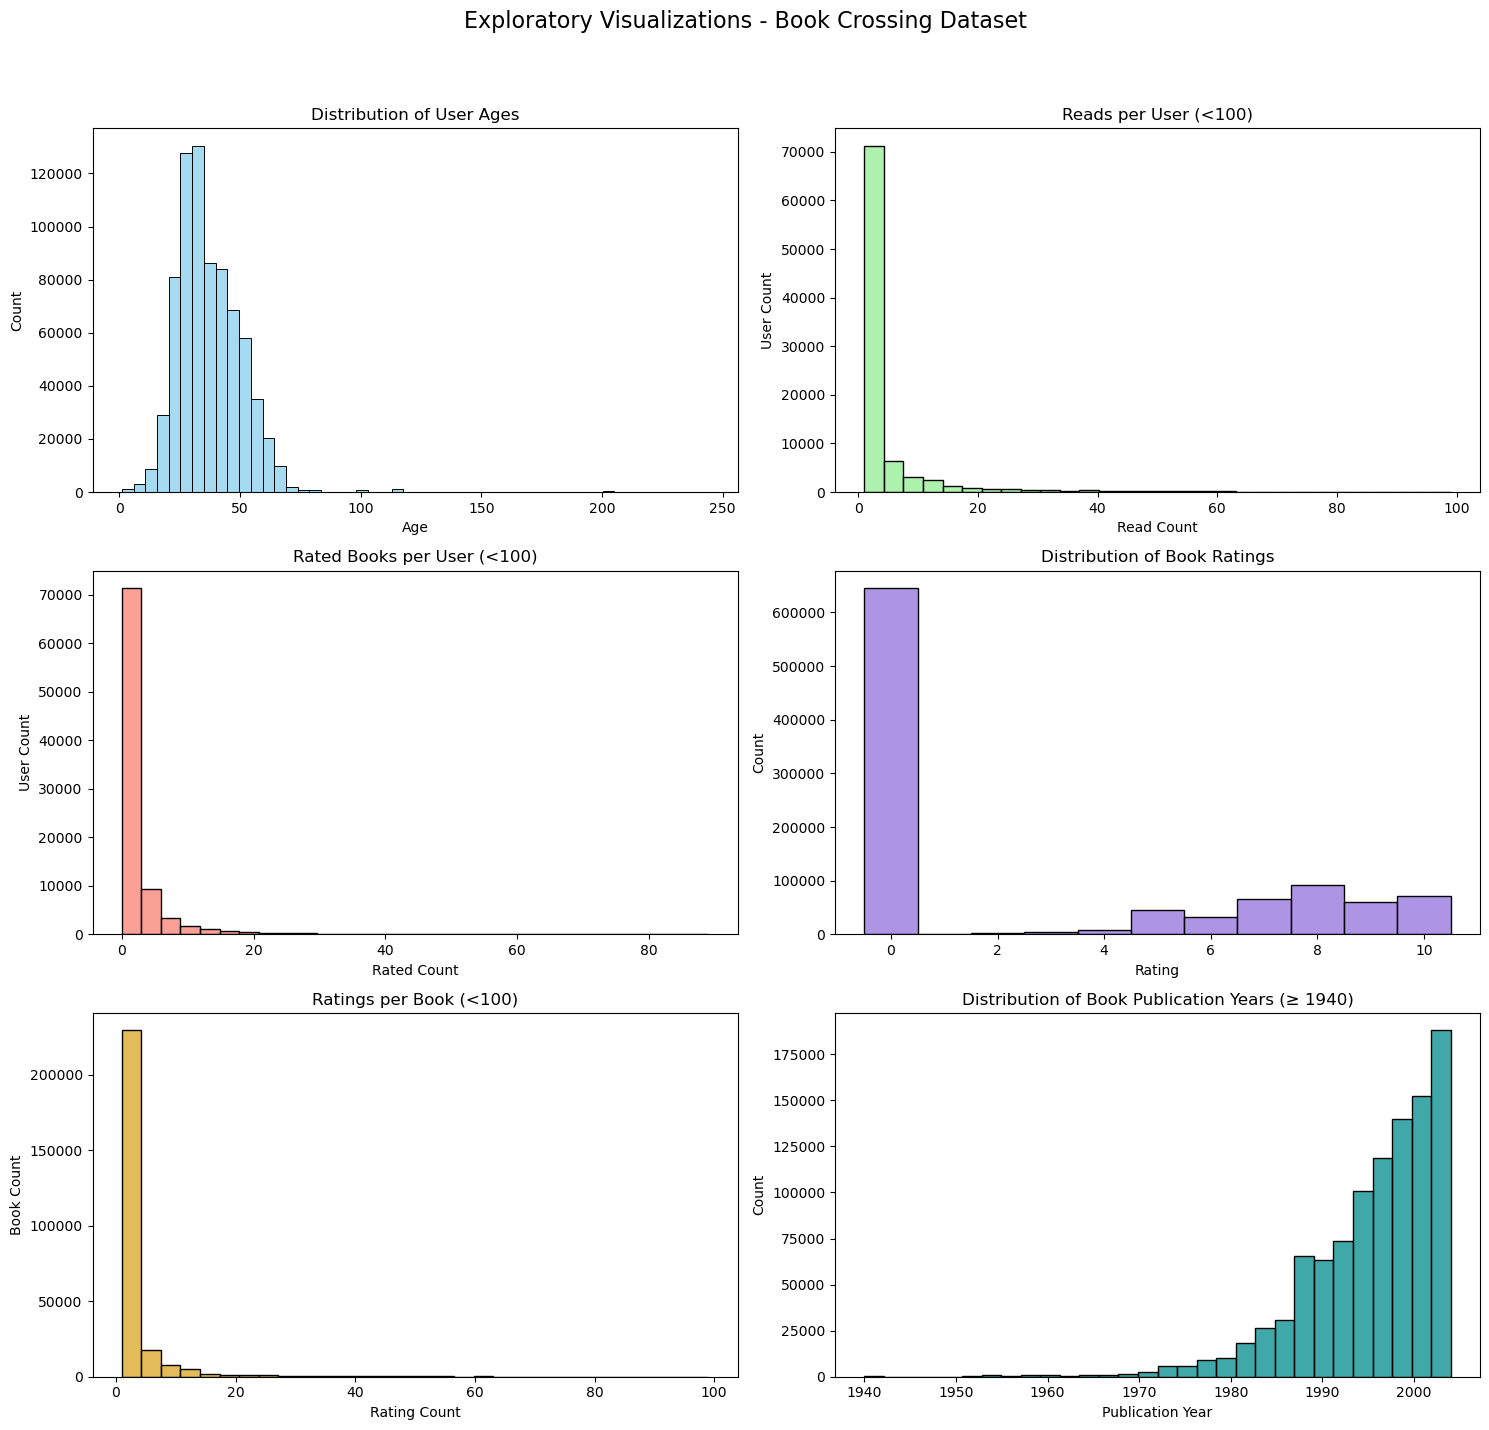

In [278]:


# Convert relevant columns to appropriate types if necessary
full_df['Age'] = pd.to_numeric(full_df['Age'], errors='coerce')
full_df['Pub_Year'] = pd.to_numeric(full_df['Pub_Year'], errors='coerce')
full_df['Book-Rating'] = pd.to_numeric(full_df['Book-Rating'], errors='coerce')


# Filter for plotting
age_data = full_df['Age'].dropna()
age_data = age_data[age_data > 0]

user_counts = full_df.groupby('User-ID')['Book-Rating'].agg(['count', lambda x: (x > 0).sum()])
user_counts.columns = ['read_cnt', 'rated_cnt']
user_counts = user_counts[user_counts['read_cnt'] < 100]

book_counts = full_df.groupby('ISBN')['Book-Rating'].agg(['count'])
book_counts.columns = ['rating_cnt']
book_counts = book_counts[book_counts['rating_cnt'] < 100]

# Set up the figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Exploratory Visualizations - Book Crossing Dataset', fontsize=16)

# Histogram: User Age
sns.histplot(age_data, bins=50, kde=False, ax=axs[0, 0], color='skyblue')
axs[0, 0].set_title('Distribution of User Ages')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Count')

# Histogram: Reads per User
sns.histplot(user_counts['read_cnt'], bins=30, kde=False, ax=axs[0, 1], color='lightgreen')
axs[0, 1].set_title('Reads per User (<100)')
axs[0, 1].set_xlabel('Read Count')
axs[0, 1].set_ylabel('User Count')

# Histogram: Ratings per User
sns.histplot(user_counts['rated_cnt'], bins=30, kde=False, ax=axs[1, 0], color='salmon')
axs[1, 0].set_title('Rated Books per User (<100)')
axs[1, 0].set_xlabel('Rated Count')
axs[1, 0].set_ylabel('User Count')

# Histogram: Book Ratings
sns.histplot(full_df['Book-Rating'], bins=10, discrete=True, kde=False, ax=axs[1, 1], color='mediumpurple')
axs[1, 1].set_title('Distribution of Book Ratings')
axs[1, 1].set_xlabel('Rating')
axs[1, 1].set_ylabel('Count')

# Histogram: Ratings per Book
sns.histplot(book_counts['rating_cnt'], bins=30, kde=False, ax=axs[2, 0], color='goldenrod')
axs[2, 0].set_title('Ratings per Book (<100)')
axs[2, 0].set_xlabel('Rating Count')
axs[2, 0].set_ylabel('Book Count')

# Histogram: Publication Year (1940 and later)
filtered_years = full_df['Pub_Year'].dropna()
filtered_years = filtered_years[filtered_years >= 1940]

sns.histplot(filtered_years, bins=30, kde=False, ax=axs[2, 1], color='darkcyan')
axs[2, 1].set_title('Distribution of Book Publication Years (≥ 1940)')
axs[2, 1].set_xlabel('Publication Year')
axs[2, 1].set_ylabel('Count')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('images/exploratory_histograms.png')
plt.show()


## Feature Engineering

In [280]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1028673 entries, 0 to 1031174
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1028673 non-null  int64 
 1   ISBN         1028673 non-null  object
 2   Book-Rating  1028673 non-null  int64 
 3   Book-Title   1028673 non-null  object
 4   Book-Author  1028671 non-null  object
 5   Publisher    1028672 non-null  object
 6   ImageURL     1028673 non-null  object
 7   Pub_Year     1018535 non-null  Int64 
 8   Location     1028673 non-null  object
 9   Age          751189 non-null   Int64 
dtypes: Int64(2), int64(2), object(6)
memory usage: 88.3+ MB


In [281]:
# User Interaction Level (User level summary level is handled later)

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Add domain-specific words to ignore
custom_stopwords = {
    'book', 'novel', 'paperback', 'volume',
    'edition', 'harlequin','story','novella','amp'
}  ## Remove , 'series'

# Combine the lists
all_stopwords = stop_words.union(custom_stopwords)

# Function to extract and lemmatize words
def extract_words(title):
    if pd.isna(title):
        return []
    # Extract words 3+ characters long
    words = re.findall(r'\b[a-zA-Z]{3,}\b', title.lower())
    # Lemmatize and filter stop words
    return [
        lemmatizer.lemmatize(word)
        for word in words
        if word not in all_stopwords
    ]




# Helper: Age quality score
def compute_age_quality(age):
    if pd.isna(age):
        return 0
    elif age == 0 or age > 99:
        return 0.5
    else:
        return 1

# Helper: Age group assignment  
def assign_age_group(age):
    if pd.isna(age) or age == 0:
        return 'Unknown'
    elif age <= 5:
        return 'Very Young'
    elif age <= 8:
        return 'Early Reader'
    elif age <= 12:
        return 'Middle Grade'
    elif age <= 18:
        return 'Young Adult'
    elif age <= 25:
        return 'Emerging Adult'
    elif age <= 40:
        return 'Early Adult'
    elif age <= 65:
        return 'Middle Adult'
    else:
        return 'Older Adult'


# Apply engagement-level features to full_df
full_df['age_quality'] = full_df['Age'].apply(compute_age_quality)
full_df['age_group'] = full_df['Age'].apply(assign_age_group)
full_df['title_words'] = full_df['Book-Title'].apply(extract_words)

# Set Age to NaN if not between 1 and 99
full_df.loc[~full_df['Age'].between(1, 99), 'Age'] = pd.NA

# Split location string into parts
location_parts = full_df['Location'].str.split(',')

# Extract from the end (right to left)
full_df['country'] = location_parts.apply(lambda x: x[-1].strip().lower() if len(x) >= 1 else None)
full_df['region']  = location_parts.apply(lambda x: x[-2].strip().lower() if len(x) >= 2 else None)
full_df['city']    = location_parts.apply(lambda x: x[-3].strip().lower() if len(x) >= 3 else None)





In [282]:
full_df.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Publisher,ImageURL,Pub_Year,Location,Age,age_quality,age_group,title_words,country,region,city
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,Ballantine Books,http://images.amazon.com/images/P/034545104X.01.THUMBZZZ.jpg,2002,"tyler, texas, usa",<NA>,0.0,Unknown,"[flesh, tone]",usa,texas,tyler
1,276726,0155061224,5,Rites of Passage,Judith Rae,Heinle,http://images.amazon.com/images/P/0155061224.01.THUMBZZZ.jpg,2001,"seattle, washington, usa",<NA>,0.0,Unknown,"[rite, passage]",usa,washington,seattle
2,276727,0446520802,0,The Notebook,Nicholas Sparks,Warner Books,http://images.amazon.com/images/P/0446520802.01.THUMBZZZ.jpg,1996,"h, new south wales, australia",16,1.0,Young Adult,[notebook],australia,new south wales,h
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,Cambridge University Press,http://images.amazon.com/images/P/052165615X.01.THUMBZZZ.jpg,1999,"rijeka, n/a, croatia",16,1.0,Young Adult,"[help, level]",croatia,n/a,rijeka
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers),Sue Leather,Cambridge University Press,http://images.amazon.com/images/P/0521795028.01.THUMBZZZ.jpg,2001,"rijeka, n/a, croatia",16,1.0,Young Adult,"[amsterdam, connection, level, cambridge, english, reader]",croatia,n/a,rijeka


In [283]:
full_df.describe()

,User-ID,Book-Rating,Pub_Year,Age,age_quality
count,1.028673e+06,1.028673e+06,1018535.0,747610.0,1.028673e+06
mean,1.405941e+05,2.843447e+00,1995.257215,37.019194,7.285109e-01
std,8.052397e+04,3.856290e+00,7.374052,12.156494,4.437490e-01
min,2.000000e+00,0.000000e+00,1376.0,1.0,0.000000e+00
25%,7.041500e+04,0.000000e+00,1992.0,28.0,0.000000e+00
50%,1.412190e+05,0.000000e+00,1997.0,35.0,1.000000e+00
75%,2.114260e+05,7.000000e+00,2001.0,45.0,1.000000e+00
max,2.788540e+05,1.000000e+01,2004.0,99.0,1.000000e+00


In [284]:
print("\nDescriptive Statistics of Categorical Variables")
cat_cols = ['Location', 'country', 'region', 'city']
full_df[cat_cols].describe(include='all')


Descriptive Statistics of Categorical Variables


,Location,country,region,city
count,1028673,1028673,1028673,1028673
unique,22320,284,1829,14594
top,"toronto, ontario, canada",usa,california,toronto
freq,14764,745289,107350,15104


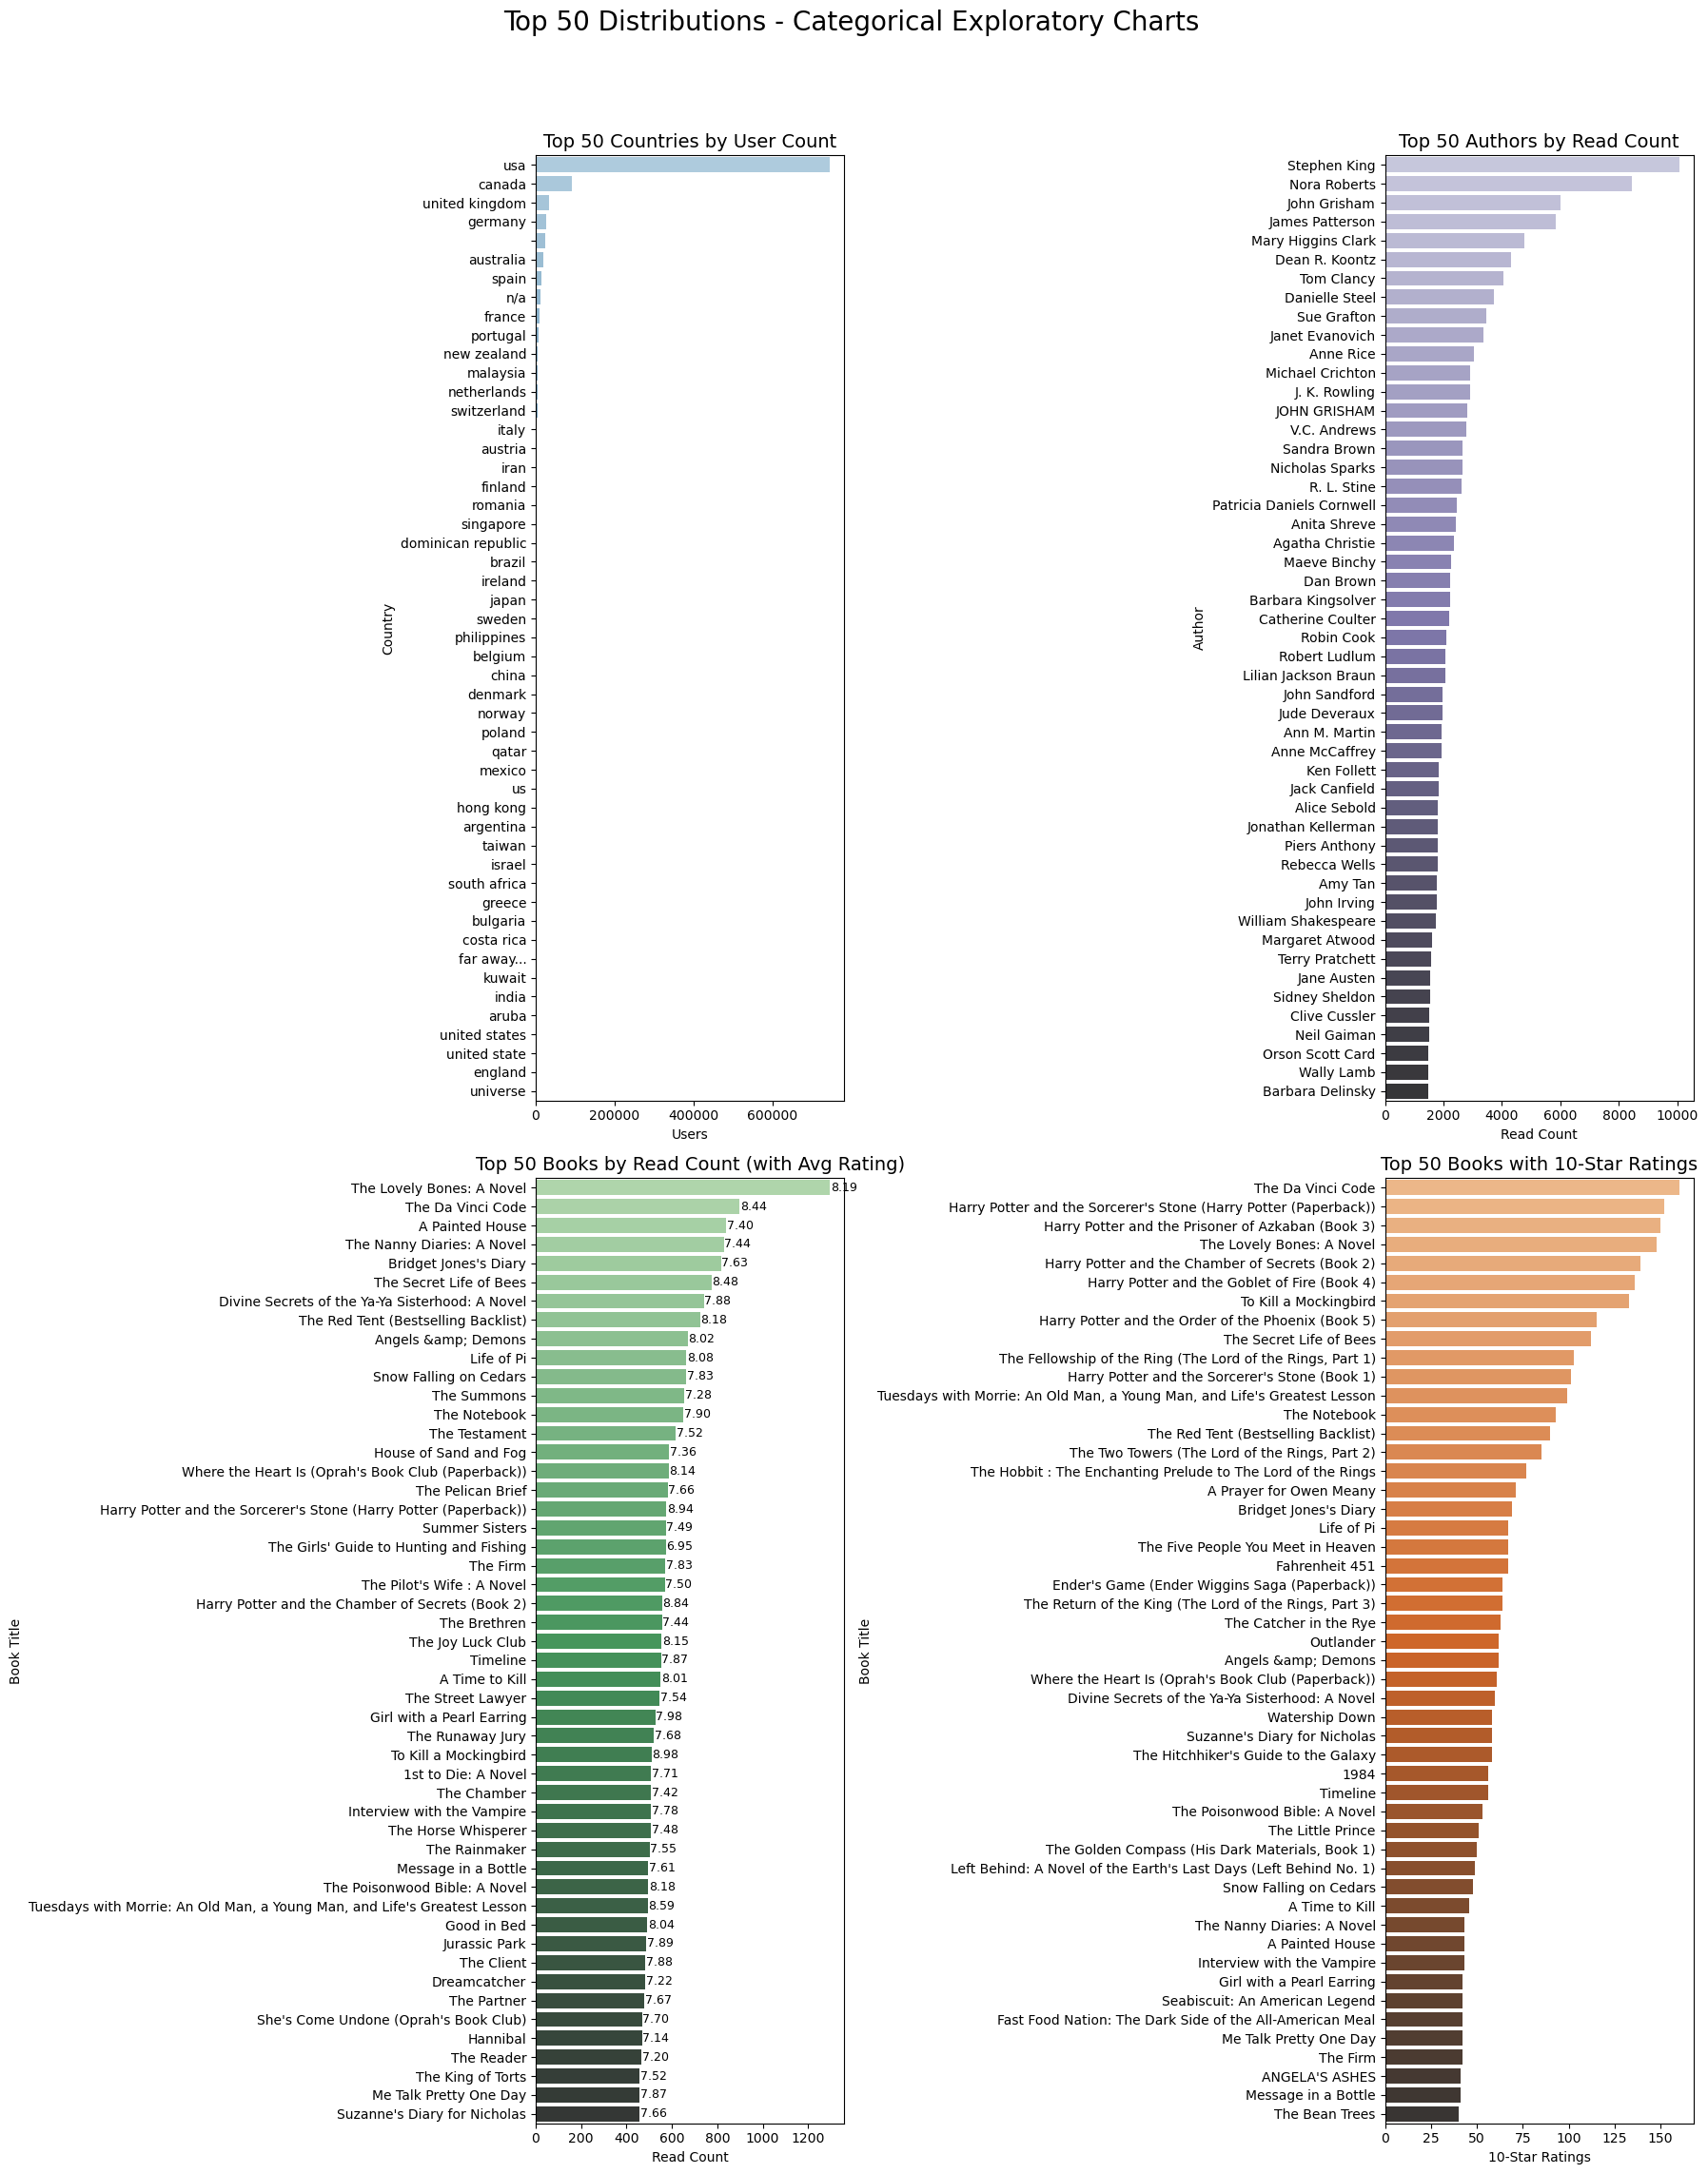

In [285]:

# Get top 50 counts
top_countries = full_df['country'].value_counts().head(50)
top_authors = full_df['Book-Author'].value_counts().head(50)
top_books_read = full_df['Book-Title'].value_counts().head(50)
top_books_rated_10 = full_df[full_df['Book-Rating'] == 10]['Book-Title'].value_counts().head(50)

# Clean avg rating per user (ignore 0s)
nonzero_ratings = full_df[full_df['Book-Rating'] > 0]
avg_ratings_clean = nonzero_ratings.groupby('Book-Title')['Book-Rating'].mean()


# Merge read count and avg rating for top books
top_books_read_df = top_books_read.to_frame(name='Read Count')
top_books_read_df['Avg Rating'] = avg_ratings_clean.reindex(top_books_read.index)

# Set up figure with extra height for spacing
fig, axs = plt.subplots(2, 2, figsize=(18, 24))
fig.suptitle('Top 50 Distributions - Categorical Exploratory Charts', fontsize=20)

# Countries
sns.barplot(y=top_countries.index, x=top_countries.values,
            hue=top_countries.index, ax=axs[0, 0],
            palette="Blues_d", legend=False)
axs[0, 0].set_title('Top 50 Countries by User Count', fontsize=14)
axs[0, 0].set_xlabel('Users')
axs[0, 0].set_ylabel('Country')

# Authors
sns.barplot(y=top_authors.index, x=top_authors.values,
            hue=top_authors.index, ax=axs[0, 1],
            palette="Purples_d", legend=False)
axs[0, 1].set_title('Top 50 Authors by Read Count', fontsize=14)
axs[0, 1].set_xlabel('Read Count')
axs[0, 1].set_ylabel('Author')

# Most Read Books - WITH Avg Rating annotation
sns.barplot(data=top_books_read_df.reset_index(),
            y='Book-Title', x='Read Count',
            hue='Book-Title', ax=axs[1, 0],
            palette="Greens_d", legend=False)
axs[1, 0].set_title('Top 50 Books by Read Count (with Avg Rating)', fontsize=14)
axs[1, 0].set_xlabel('Read Count')
axs[1, 0].set_ylabel('Book Title')

# Annotate average ratings next to bars
for i, (count, avg) in enumerate(zip(top_books_read_df['Read Count'], top_books_read_df['Avg Rating'])):
    if pd.notna(avg):
        axs[1, 0].text(count + 3, i, f"{avg:.2f}", va='center', fontsize=9, color='black')

# Books Rated 10
sns.barplot(y=top_books_rated_10.index, x=top_books_rated_10.values,
            hue=top_books_rated_10.index, ax=axs[1, 1],
            palette="Oranges_d", legend=False)
axs[1, 1].set_title('Top 50 Books with 10-Star Ratings', fontsize=14)
axs[1, 1].set_xlabel('10-Star Ratings')
axs[1, 1].set_ylabel('Book Title')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('images/Top50Distributions.png')
plt.show()



### Eligibility Filtering

The dataset is filtered to U.S. users to reduce geographic imbalance and simplify analysis. This also enables the use of latitude and longitude for meaningful location-based clustering.

In [287]:
# Filter for USA only
usa_df = full_df[(full_df['country'] == 'usa')].copy()

# Filter for book ratinges between 1-10 inclusive
usa_df = usa_df[(usa_df['Book-Rating'] >= 1) & (usa_df['Book-Rating'] <= 10)]

# Rename region ==> state
usa_df = usa_df.rename(columns={'region': 'state'})


print(f"Filtered dataset shape: {usa_df.shape}")
print(f"Unique users: {usa_df['User-ID'].nunique()}")


Filtered dataset shape: (262170, 16)
Unique users: 44066


In [288]:
# Load uscities.csv from https://simplemaps.com/data/us-cities to get lat and lng
cities_df = pd.read_csv('data/uscities.csv', encoding='latin-1', sep=',', on_bad_lines='skip')

cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31254 entries, 0 to 31253
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          31254 non-null  object 
 1   city_ascii    31254 non-null  object 
 2   state_id      31254 non-null  object 
 3   state_name    31254 non-null  object 
 4   county_fips   31254 non-null  int64  
 5   county_name   31254 non-null  object 
 6   lat           31254 non-null  float64
 7   lng           31254 non-null  float64
 8   population    31254 non-null  int64  
 9   density       31254 non-null  float64
 10  source        31254 non-null  object 
 11  military      31254 non-null  bool   
 12  incorporated  31254 non-null  bool   
 13  timezone      31254 non-null  object 
 14  ranking       31254 non-null  int64  
 15  zips          31252 non-null  object 
 16  id            31254 non-null  int64  
dtypes: bool(2), float64(3), int64(4), object(8)
memory usage: 3.6+ MB


In [289]:
# Load manually updated file
loc_update_df = pd.read_csv("data/loc_lat_lng.csv")

loc_update_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Location     110 non-null    object 
 1   state        109 non-null    object 
 2   state_clean  109 non-null    object 
 3   city         108 non-null    object 
 4   lat          110 non-null    float64
 5   lng          110 non-null    float64
dtypes: float64(2), object(4)
memory usage: 5.3+ KB


In [290]:
#  Standardize and clean STATE
# Step 1: Define US states and their abbreviations (standard + common variations)
us_states = {
    'alabama': 'al', 'alaska': 'ak', 'arizona': 'az', 'arkansas': 'ar', 'california': 'ca',
    'colorado': 'co', 'connecticut': 'ct', 'delaware': 'de', 'florida': 'fl', 'georgia': 'ga',
    'hawaii': 'hi', 'idaho': 'id', 'illinois': 'il', 'indiana': 'in', 'iowa': 'ia',
    'kansas': 'ks', 'kentucky': 'ky', 'louisiana': 'la', 'maine': 'me', 'maryland': 'md',
    'massachusetts': 'ma', 'michigan': 'mi', 'minnesota': 'mn', 'mississippi': 'ms', 'missouri': 'mo',
    'montana': 'mt', 'nebraska': 'ne', 'nevada': 'nv', 'new hampshire': 'nh', 'new jersey': 'nj',
    'new mexico': 'nm', 'new york': 'ny', 'north carolina': 'nc', 'north dakota': 'nd',
    'ohio': 'oh', 'oklahoma': 'ok', 'oregon': 'or', 'pennsylvania': 'pa', 'rhode island': 'ri',
    'south carolina': 'sc', 'south dakota': 'sd', 'tennessee': 'tn', 'texas': 'tx', 'utah': 'ut',
    'vermont': 'vt', 'virginia': 'va', 'washington': 'wa', 'west virginia': 'wv',
    'wisconsin': 'wi', 'wyoming': 'wy', 'district of columbia': 'dc',

    # Concatenated variants
    'newyork': 'ny', 'newjersey': 'nj', 'northcarolina': 'nc', 'southcarolina': 'sc',
    'westvirginia': 'wv', 'newmexico': 'nm', 'newhampshire': 'nh', 'rhodeisland': 'ri',
    'southdakota': 'sd', 'northdakota': 'nd', 'westernpennsylvania':'pa','scarolina':'sc',
    'washingtonstate':'wa', 'floridakeys':'fl', 'upstatenewyork': 'ny',
}



# Create reverse mapping for abbreviations
abbr_to_abbr = {abbr: abbr for abbr in us_states.values()}

# Combine into one full mapping
state_lookup = {**us_states, **abbr_to_abbr}

# Step 2: Clean and standardize state names
usa_df['state'] = usa_df['state'].str.lower().str.replace(r'[^a-z]', '', regex=True)

# Step 3: Map to standard two-letter abbreviations
usa_df['state_clean'] = usa_df['state'].map(state_lookup)

# Preview mismatches or unmapped states
unmapped_states = usa_df[usa_df['state_clean'].isna()]['state'].value_counts()
unmapped_states.head(20)


state
                                          852
na                                        336
ap                                        254
ae                                         97
puertorico                                 49
unknown                                    37
yedor                                      24
myownlittleworld                           19
virginislands                              18
armedforcespacific                         16
rheinlandpfalz                             13
armedforceseurope                          13
tasmania                                   13
armedserviceseurope                        11
calabria                                   10
michigannewjersey                           9
anywhereusa                                 7
travelingnursedomonthsatatimealloverus      6
moving                                      6
usa                                         6
Name: count, dtype: int64

In [291]:

# Ensure state and city names are clean and lowercase
usa_df['city'] = usa_df['city'].str.lower().str.strip()
usa_df['state_clean'] = usa_df['state_clean'].str.lower().str.strip()
cities_df['city'] = cities_df['city'].str.lower().str.strip()
cities_df['state_id'] = cities_df['state_id'].str.lower().str.strip()

# Perform merge on both city and state_id to ensure correct match
usa_df = pd.merge(
    usa_df,
    cities_df[['city', 'state_id', 'lat', 'lng']],
    left_on=['city', 'state_clean'],
    right_on=['city', 'state_id'],
    how='left'
)

# Drop the redundant right-side state_id column
usa_df.drop(columns=['state_id'], inplace=True)


# Merge directly on Location
usa_df = usa_df.merge(
    loc_update_df[['Location', 'lat', 'lng']],
    on='Location',
    how='left',
    suffixes=('', '_manual')
)

# Fill missing values from manual source only if lat/lng are NaN
usa_df['lat'] = usa_df['lat'].fillna(usa_df['lat_manual'])
usa_df['lng'] = usa_df['lng'].fillna(usa_df['lng_manual'])

# Drop temp columns
usa_df.drop(columns=['lat_manual', 'lng_manual'], inplace=True)


# Preview results
print(usa_df[['Location', 'state_clean', 'city', 'lat', 'lng']].head())


                    Location state_clean       city      lat       lng
0   seattle, washington, usa          wa    seattle  47.6211 -122.3244
1  torrance, california, usa          ca   torrance  33.8346 -118.3416
2       iowa city, iowa, usa          ia  iowa city  41.6559  -91.5303
3       iowa city, iowa, usa          ia  iowa city  41.6559  -91.5303
4       iowa city, iowa, usa          ia  iowa city  41.6559  -91.5303


In [292]:
usa_df.describe()

,User-ID,Book-Rating,Pub_Year,Age,age_quality,lat,lng
count,262353.000000,262353.000000,261435.0,184591.0,262353.000000,244082.000000,244082.000000
mean,138185.862647,7.680987,1995.768394,37.613773,0.704928,37.986328,-95.261097
std,79388.892700,1.840981,7.257579,12.485451,0.455346,5.559742,18.813721
min,9.000000,1.000000,1806.0,1.0,0.000000,19.530600,-166.568000
25%,70302.000000,7.000000,1993.0,29.0,0.000000,33.953300,-112.089200
50%,135355.000000,8.000000,1998.0,36.0,1.000000,38.627000,-88.864900
75%,208019.000000,9.000000,2001.0,47.0,1.000000,41.510000,-81.090700
max,278854.000000,10.000000,2004.0,99.0,1.000000,70.314800,-67.224000


In [293]:
usa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262353 entries, 0 to 262352
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   User-ID      262353 non-null  int64  
 1   ISBN         262353 non-null  object 
 2   Book-Rating  262353 non-null  int64  
 3   Book-Title   262353 non-null  object 
 4   Book-Author  262353 non-null  object 
 5   Publisher    262352 non-null  object 
 6   ImageURL     262353 non-null  object 
 7   Pub_Year     261435 non-null  Int64  
 8   Location     262353 non-null  object 
 9   Age          184591 non-null  Int64  
 10  age_quality  262353 non-null  float64
 11  age_group    262353 non-null  object 
 12  title_words  262353 non-null  object 
 13  country      262353 non-null  object 
 14  state        262353 non-null  object 
 15  city         262353 non-null  object 
 16  state_clean  260458 non-null  object 
 17  lat          244082 non-null  float64
 18  lng          244082 non-

In [294]:
#  Generate SBERT sentence embeddings for each book by combining its title and author 

# Load the SBERT model (MiniLM is fast and well-suited for clustering/search)
model = SentenceTransformer('all-MiniLM-L6-v2')

sentences = usa_df['Book-Title'].fillna('') + ' by ' + usa_df['Book-Author'].fillna('')
title_author_embeddings = model.encode(sentences.tolist(), batch_size=64, show_progress_bar=False)

embeddings_df = pd.DataFrame(title_author_embeddings)

# Join the SBERT embeddings back to usa_df
# Rename SBERT columns first
embeddings_df.columns = [f'sbert_dim_{i}' for i in range(embeddings_df.shape[1])]

# Concatenate all at once for speed and efficiency
usa_df = pd.concat([usa_df.reset_index(drop=True), embeddings_df], axis=1)




In [295]:
usa_df.isnull().sum()[lambda x: x > 0]



Publisher          1
Pub_Year         918
Age            77762
state_clean     1895
lat            18271
lng            18271
dtype: int64

In [296]:

# Drop all rows with any NaNs EXCEPT in the 'Age' column
cols_to_check = usa_df.columns.drop('Age')  # All columns except Age
usa_df_cleaned = usa_df.dropna(subset=cols_to_check)


usa_df_cleaned.shape


(243168, 403)

In [297]:
usa_df_cleaned.isnull().sum()[lambda x: x > 0]


Age    70706
dtype: int64

#### Histogram of Books per User to check for outliers

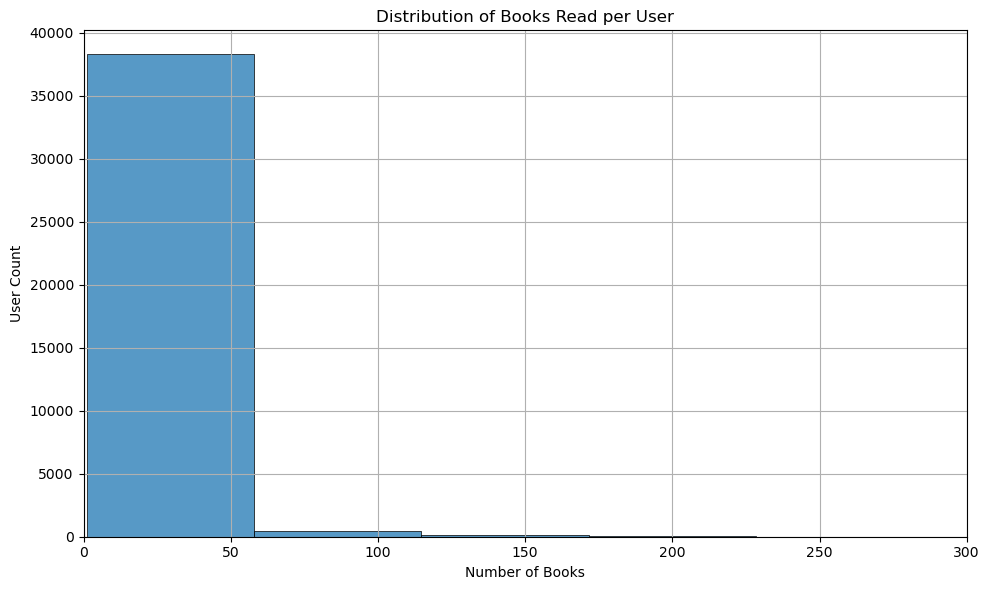

In [299]:
# Count the number of rows per user (i.e., how many books they rated)
books_per_user = usa_df_cleaned.groupby('User-ID').size().rename("read_count").reset_index()

# Plot Histogram
plt.figure(figsize=(10, 6))
sns.histplot(books_per_user['read_count'], bins=100, kde=False)
plt.title("Distribution of Books Read per User")
plt.xlabel("Number of Books")
plt.ylabel("User Count")
plt.grid(True)
plt.xlim(0, 300)  # You can adjust or remove this to show full range
plt.tight_layout()
plt.show()




### Create User Level Summary Data Table

In [301]:
# Step: Summarize SBERT embeddings to user level
sbert_cols = [col for col in usa_df_cleaned.columns if col.startswith('sbert_dim_')]

# Compute the mean SBERT vector per user
user_sbert_summary = usa_df_cleaned.groupby('User-ID')[sbert_cols].mean().reset_index()


In [302]:
# Step: Aggregate usa_df_cleaned to user-level summary
usa_user_summary = usa_df_cleaned.groupby('User-ID').agg(
    Age=('Age', 'first'), 
    age_quality=('age_quality', 'first'),
    age_group=('age_group', 'first'), 
    state=('state_clean', 'first'),
    city=('city', 'first'),
    lat=('lat', 'first'),
    lng=('lng', 'first'),
    read_cnt=('User-ID', 'count'),
    rated_cnt=('Book-Rating', lambda x: (x > 0).sum()),
    rated_high_cnt=('Book-Rating', lambda x: (x > 7).sum()),
    rated_med_cnt=('Book-Rating', lambda x: x.between(4, 7).sum()),
    rated_low_cnt=('Book-Rating', lambda x: x.between(1, 3).sum()),
    rated_average=('Book-Rating', lambda x: x[x > 0].mean() if (x > 0).any() else 0),
    author_cnt=('Book-Author', pd.Series.nunique),
    publisher_cnt=('Publisher', pd.Series.nunique),  
    pub_current_cnt=('Pub_Year', lambda x: x.between(2000, 2004).sum()),
    pub_90s_cnt=('Pub_Year', lambda x: x.between(1990, 1999).sum()),
    pub_80s_cnt=('Pub_Year', lambda x: x.between(1980, 1989).sum()),
    pub_70s_cnt=('Pub_Year', lambda x: x.between(1970, 1979).sum()),
    pub_classic_cnt=('Pub_Year', lambda x: (x < 1970).sum())
).reset_index()





In [303]:
# Step: Merge SBERT user-level embeddings into the full summary
usa_user_summary = usa_user_summary.merge(user_sbert_summary, on='User-ID', how='left')


In [304]:
usa_user_summary.head()



,User-ID,Age,age_quality,age_group,state,city,lat,lng,read_cnt,rated_cnt,...,sbert_dim_374,sbert_dim_375,sbert_dim_376,sbert_dim_377,sbert_dim_378,sbert_dim_379,sbert_dim_380,sbert_dim_381,sbert_dim_382,sbert_dim_383
0,9,<NA>,0.0,Unknown,tn,germantown,35.0829,-89.7824,1,1,...,0.003377,-0.009303,-0.051621,0.110522,-0.024936,-0.014148,0.062965,0.029737,0.019691,-0.130410
1,12,<NA>,0.0,Unknown,ca,fort bragg,39.4399,-123.8013,1,1,...,0.104754,0.036627,-0.011681,0.108640,-0.011094,-0.041146,0.119531,0.042739,-0.035129,0.025961
2,14,<NA>,0.0,Unknown,ia,mediapolis,41.0079,-91.1636,3,3,...,0.045259,0.010414,-0.000262,0.036045,0.009522,-0.006715,0.061217,0.021402,0.008910,-0.020668
3,16,<NA>,0.0,Unknown,nm,albuquerque,35.1054,-106.6465,1,1,...,0.067623,0.022869,-0.007900,0.070553,-0.013500,-0.080098,-0.021437,0.077154,-0.058273,-0.007726
4,17,<NA>,0.0,Unknown,va,chesapeake,36.6778,-76.3023,4,4,...,0.013068,0.017560,-0.004763,0.071382,-0.066284,-0.038043,0.073805,0.047359,0.005980,-0.012408


In [305]:
# Step: Adjust usa_user_summary to include additional features
# Start by setting index for joining
# usa_user_summary = usa_user_summary.set_index('User-ID') # ALREADY SET

# Favorite book, author and publisher from usa_df_cleaned
mostread_book = usa_df_cleaned.groupby('User-ID')['Book-Title'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
favorite_authors = usa_df_cleaned.groupby('User-ID')['Book-Author'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)
favorite_publishers = usa_df_cleaned.groupby('User-ID')['Publisher'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA)

# Add these to summary
usa_user_summary['favorite_author'] = favorite_authors
usa_user_summary['mostread_book'] = mostread_book
usa_user_summary['favorite_publisher'] = favorite_publishers

# Determine favorite publication era  
era_cols = ['pub_current_cnt', 'pub_90s_cnt', 'pub_80s_cnt', 'pub_70s_cnt', 'pub_classic_cnt']
era_labels = {
    'pub_current_cnt': '2000s',
    'pub_90s_cnt': '1990s',
    'pub_80s_cnt': '1980s',
    'pub_70s_cnt': '1970s',
    'pub_classic_cnt': 'Classic'
}
usa_user_summary['fav_pub_era'] = usa_user_summary[era_cols].idxmax(axis=1).map(era_labels)

# Add diversity ratios
usa_user_summary['author_diversity'] = usa_user_summary['author_cnt'] / usa_user_summary['read_cnt']
usa_user_summary['publisher_diversity'] = usa_user_summary['publisher_cnt'] / usa_user_summary['read_cnt'] 

# Drop redundant raw counts
usa_user_summary.drop(columns=['author_cnt'], inplace=True)


In [306]:
# All titles the user interacted with (interest)
interest_title_words = usa_df_cleaned.groupby('User-ID')['title_words'].agg(
    lambda x: ' <sep> '.join([' '.join(words) for words in x])
)

# Titles rated > 8 (favorites only)
fav_title_words = (
    usa_df_cleaned[usa_df_cleaned['Book-Rating'] > 8]
    .groupby('User-ID')['title_words']
    .agg(lambda x: ' <sep> '.join([' '.join(words) for words in x]))
)


In [307]:
# Generate title word summaries
interest_title_words = usa_df_cleaned.groupby('User-ID')['title_words'].agg(
    lambda x: ' <sep> '.join([' '.join(words) for words in x])
)

fav_title_words = usa_df_cleaned[usa_df_cleaned['Book-Rating'] > 8].groupby('User-ID')['title_words'].agg(
    lambda x: ' <sep> '.join([' '.join(words) for words in x])
)

# Merge back into the user summary
usa_user_summary = usa_user_summary.merge(interest_title_words.rename("interest_title_words"), on='User-ID', how='left')
usa_user_summary = usa_user_summary.merge(fav_title_words.rename("fav_title_words"), on='User-ID', how='left')

# Fill null records with 'none'
usa_user_summary['fav_title_words'] = usa_user_summary['fav_title_words'].fillna('none')



In [308]:
usa_user_summary.head()

,User-ID,Age,age_quality,age_group,state,city,lat,lng,read_cnt,rated_cnt,...,sbert_dim_382,sbert_dim_383,favorite_author,mostread_book,favorite_publisher,fav_pub_era,author_diversity,publisher_diversity,interest_title_words,fav_title_words
0,9,<NA>,0.0,Unknown,tn,germantown,35.0829,-89.7824,1,1,...,0.019691,-0.130410,NaN,NaN,NaN,1990s,1.00,1.00,beloved plume contemporary fiction,none
1,12,<NA>,0.0,Unknown,ca,fort bragg,39.4399,-123.8013,1,1,...,-0.035129,0.025961,NaN,NaN,NaN,2000s,1.00,1.00,known know learn mistake others afford make,known know learn mistake others afford make
2,14,<NA>,0.0,Unknown,ia,mediapolis,41.0079,-91.1636,3,3,...,0.008910,-0.020668,NaN,NaN,NaN,1990s,1.00,1.00,mary kate ashley switching goal mary kate ashley starring <sep> tell happening <sep> flood mississippi,none
3,16,<NA>,0.0,Unknown,nm,albuquerque,35.1054,-106.6465,1,1,...,-0.058273,-0.007726,NaN,NaN,NaN,1990s,1.00,1.00,airframe,airframe
4,17,<NA>,0.0,Unknown,va,chesapeake,36.6778,-76.3023,4,4,...,0.005980,-0.012408,NaN,NaN,NaN,1990s,0.75,0.75,death cloud <sep> bant spec last breed <sep> piercing darkness <sep> prophet,none


In [309]:
non_sbert_cols = [col for col in usa_user_summary.columns if not col.startswith('sbert_dim_')]
usa_user_summary[non_sbert_cols].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38951 entries, 0 to 38950
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   User-ID               38951 non-null  int64  
 1   Age                   21877 non-null  Int64  
 2   age_quality           38951 non-null  float64
 3   age_group             38951 non-null  object 
 4   state                 38951 non-null  object 
 5   city                  38951 non-null  object 
 6   lat                   38951 non-null  float64
 7   lng                   38951 non-null  float64
 8   read_cnt              38951 non-null  int64  
 9   rated_cnt             38951 non-null  int64  
 10  rated_high_cnt        38951 non-null  int64  
 11  rated_med_cnt         38951 non-null  int64  
 12  rated_low_cnt         38951 non-null  int64  
 13  rated_average         38951 non-null  float64
 14  publisher_cnt         38951 non-null  int64  
 15  pub_current_cnt    

In [310]:
# Check uniqueness of User-ID
usa_user_summary = usa_user_summary.reset_index()  # make sure User-ID is a column, not index

unique_user_ids = usa_user_summary['User-ID'].nunique()
total_rows = usa_user_summary.shape[0]

print(f"Unique User-IDs: {unique_user_ids}")
print(f"Total Rows:      {total_rows}")

if unique_user_ids == total_rows:
    print("✅ Pass: 1 row per user.")
else:
    print("❌ Warning: Duplicate user rows detected.")

Unique User-IDs: 38951
Total Rows:      38951
✅ Pass: 1 row per user.


### Train/Test Split for future exploration

In [312]:


# Train/test split at the user level
user_ids = usa_user_summary['User-ID'].unique()
train_ids, test_ids = train_test_split(user_ids, test_size=0.2, random_state=42)

# Create train and test sets from user summary
train_df = usa_user_summary[usa_user_summary['User-ID'].isin(train_ids)].copy()
test_df = usa_user_summary[usa_user_summary['User-ID'].isin(test_ids)].copy()

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")


Train shape: (31160, 413)
Test shape: (7791, 413)


## Modeling


### Preprocessor

In [371]:
# Drop features I want to keep for profiling only (not clustering)
features_to_exclude = [
    'Age',                   # keep for personas
    'publisher_diversity',   # dropped per simplification
    'interest_title_words',  # replaced by SBERT
    'fav_title_words',       # replaced by SBERT
    'pub_current_cnt',       # drop era counts 
    'pub_90s_cnt',
    'pub_80s_cnt',
    'pub_70s_cnt',
    'pub_classic_cnt',
    'fav_pub_era'            # keep for profiling/visualization only
]

# Make a copy and safely filter
filtered_train_df = train_df.copy()
filtered_train_df.drop(columns=[col for col in features_to_exclude if col in filtered_train_df.columns], inplace=True)

# Identify SBERT features
sbert_features = [col for col in filtered_train_df.columns if col.startswith('sbert_dim_')]


# Identify numeric columns to scale 
scale_features = filtered_train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Exclude SBERT, User-ID, and any other non-scalables
scale_features = [
    col for col in scale_features
    if col not in ['User-ID', 'age_quality'] and not col.startswith('sbert_dim_')
]

# # One-hot encoding for fav_pub_era  #DROPPED FROM CLUSTERING FEATURES DUE TO ITS SKEWED DISTRIBUTION
# categorical_features = ['fav_pub_era'] 

#  REPLACE TF_IDF VECTORIZATION WITH SBERT 
# # TF-IDF vectorization (ngram=2, tuned options)
# text_features = ['interest_title_words', 'fav_title_words']
# text_transformers = [ 
#     ('tfidf_interest', TfidfVectorizer(ngram_range=(1, 2), max_features=10, min_df=3, max_df=0.8), 'interest_title_words'),
#     ('tfidf_fav', TfidfVectorizer(ngram_range=(1, 2), max_features=10, min_df=3, max_df=0.8), 'fav_title_words')
# ]


# Build ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), scale_features),
        # ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features), 
        ('sbert', 'passthrough', sbert_features)
        # *text_transformers  #CONVERT TO USING SBERT INSTEAD OF TF-IDF,
       
    ]
)



X_cluster = preprocessor.fit_transform(filtered_train_df)
print("Preprocessed X_cluster shape:", X_cluster.shape)


Preprocessed X_cluster shape: (31160, 395)


In [373]:


# Step 1: Convert X_cluster to dense format
X_dense = X_cluster if isinstance(X_cluster, np.ndarray) else X_cluster.toarray()

# Step 2: Identify NaNs
nan_mask = np.isnan(X_dense)
nan_counts = nan_mask.sum(axis=0)
missing_indices = np.where(nan_counts > 0)[0]

# Step 3: Get feature names from your preprocessor
feature_names = preprocessor.get_feature_names_out()

# Step 4: Map indices to feature names
missing_column_names = [feature_names[i] for i in missing_indices]

# Display
print("Columns with missing values:")
for name in missing_column_names:
    print(f" - {name}")



Columns with missing values:


## 🤖 Baseline Clustering (KMeans)


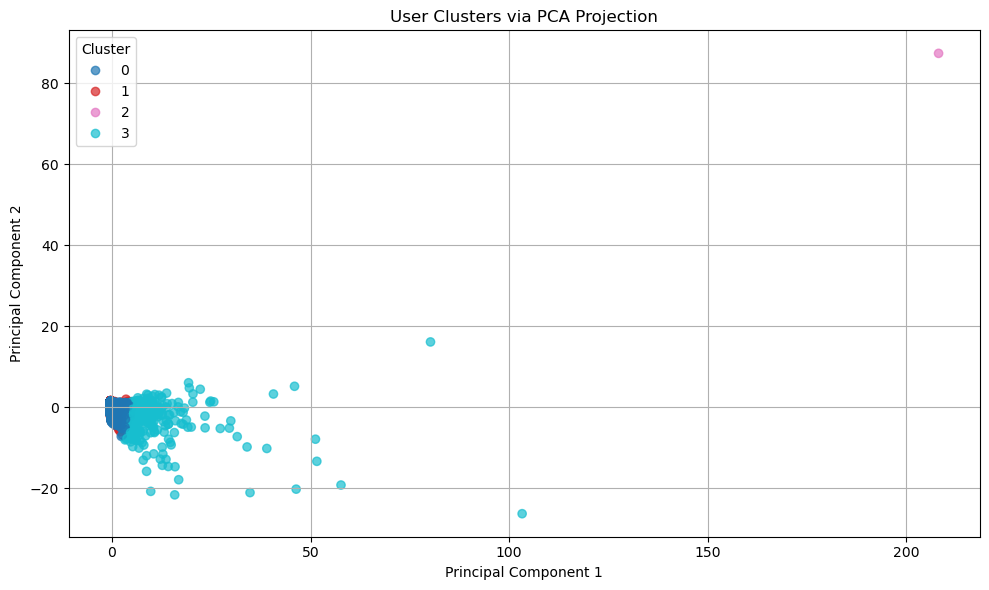

In [376]:


# Step 1: Run KMeans with chosen number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_cluster)

# Step 2: Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_cluster)


# Step 3: Create a DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': cluster_labels
})

# Step 4: Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='tab10', alpha=0.7)
plt.title("User Clusters via PCA Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.savefig('images/userclustersviaPCA.png')
plt.tight_layout()

plt.show()



In [378]:
# Create a temporary DataFrame to check cluster counts
temp_df = filtered_train_df[['User-ID']].copy()
temp_df['persona_cluster'] = cluster_labels

# Count cluster sizes
print("🔢 Cluster Counts:")
print(temp_df['persona_cluster'].value_counts(dropna=False))

# Proportions
print("\n📊 Cluster Proportions:")
print(temp_df['persona_cluster'].value_counts(normalize=True, dropna=False).round(3))



🔢 Cluster Counts:
persona_cluster
0    15369
1    15346
3      444
2        1
Name: count, dtype: int64

📊 Cluster Proportions:
persona_cluster
0    0.493
1    0.492
3    0.014
2    0.000
Name: proportion, dtype: float64


In [380]:

score = silhouette_score(X_cluster, cluster_labels)
print(f"Silhouette Score: {score:.3f}")


Silhouette Score: 0.136


## 🤖 DBSCAN Clustering (Range of eps values)

In [382]:
# Range of eps Values
eps_values = np.arange(0.3, 1.2, 0.1)
silhouette_scores = []
num_clusters = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X_cluster)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters.append(n_clusters)

    if n_clusters > 1:
        score = silhouette_score(X_cluster, labels)
    else:
        score = -1  # invalid silhouette score if only one cluster
    silhouette_scores.append(score)

    print(f"eps={eps:.2f} → Clusters={n_clusters}, Silhouette Score={score:.3f}")


eps=0.30 → Clusters=0, Silhouette Score=-1.000
eps=0.40 → Clusters=0, Silhouette Score=-1.000
eps=0.50 → Clusters=7, Silhouette Score=-0.410
eps=0.60 → Clusters=56, Silhouette Score=-0.531
eps=0.70 → Clusters=54, Silhouette Score=-0.480
eps=0.80 → Clusters=60, Silhouette Score=-0.464
eps=0.90 → Clusters=34, Silhouette Score=-0.389
eps=1.00 → Clusters=32, Silhouette Score=-0.239
eps=1.10 → Clusters=27, Silhouette Score=0.013


### What This Tells Us:

* DBSCAN is **fragmenting** the data — producing many small, noisy clusters.
* Silhouette scores < 0 mean **on average**, users are closer to points in other clusters than in their own — this is a red flag.
---
## ⚠️ Why DBSCAN Isn’t Ideal Here
| Challenge                                    | Reason                                                                      |
| -------------------------------------------- | --------------------------------------------------------------------------- |
| **High-dimensional SBERT + numeric vectors** | DBSCAN struggles with non-linear dense embeddings + numeric mix             |
| **Semantic distances not Euclidean**         | Cosine similarity is more appropriate, but DBSCAN uses Euclidean by default |
| **Poor interpretability**                    | 50+ clusters is hard to visualize or act on                                 |
| **Unbalanced user distributions**            | Most users fall into just 1–2 clusters (or are labeled noise)               |




## 🔍 Why Not Tune Further?

| Reason                      | Explanation                                                                                            |
| --------------------------- | ------------------------------------------------------------------------------------------------------ |
| ❌ Poor fit for data type    | High-dimensional, sparse vectors make distance-based density estimation unreliable                     |
| ❌ Already tested key ranges | You tried `eps = 0.3 to 1.1`, which is standard — no improvement seen                                  |
| ❌ Business irrelevance      | Even if it clustered well, the segments are too small to meaningfully personalize marketing            |
| ✅ Better alternatives exist | KMeans and Agglomerative (especially `n=4`) are producing more **interpretable** groups |



## 🤖 Agglomerative Clustering (n_clusters = 4)

In [386]:
## Run Agglomerative Clustering (type of Heirarchial clustering,  n_clusters = 4 to start)

agglo = AgglomerativeClustering(n_clusters=4, linkage='ward')
agglo_labels = agglo.fit_predict(X_dense)




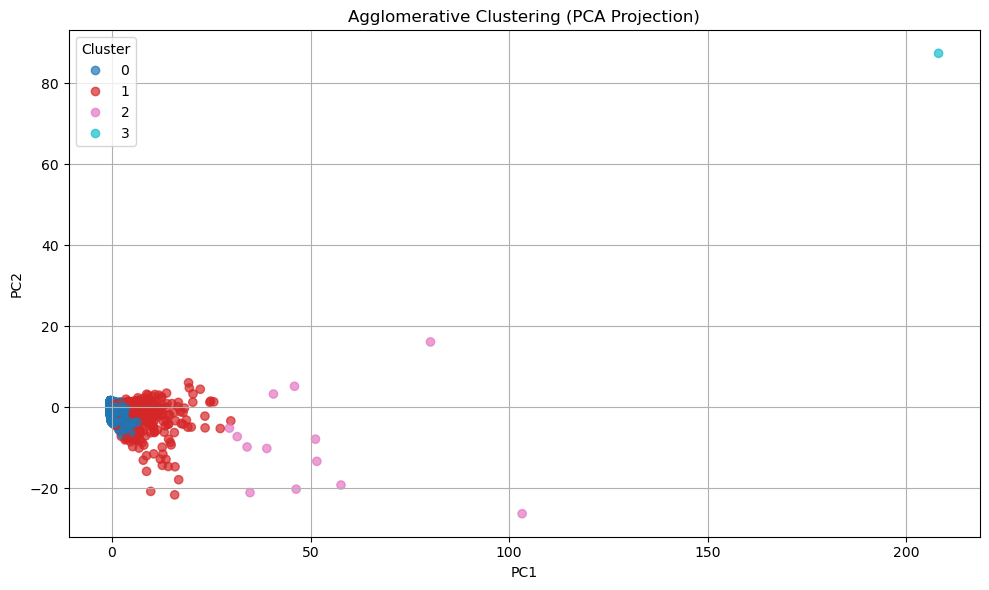

In [387]:

X_pca = PCA(n_components=2, random_state=42).fit_transform(X_cluster)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='tab10', alpha=0.7)
plt.title("Agglomerative Clustering (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [388]:
# Attached labels to user summary
agglo_df = train_df[['User-ID']].copy()
agglo_df['agglo_cluster'] = agglo_labels

# Safely drop all columns related to agglo_cluster (e.g., agglo_cluster, agglo_cluster_x, etc.)
cols_to_drop = [col for col in usa_user_summary.columns if col.startswith('agglo_cluster')]
usa_user_summary = usa_user_summary.drop(columns=cols_to_drop)

# Now merge
usa_user_summary = usa_user_summary.merge(agglo_df, on='User-ID', how='left')


# Filter to only users with a persona_cluster assigned (i.e., non-null clusters)
clustered_users = usa_user_summary[usa_user_summary['agglo_cluster'].notna()].copy()

# Preview the updated DataFrame
print("Cluster labels added to usa_user_summary:")
display(clustered_users[['User-ID', 'agglo_cluster']].head())


Cluster labels added to usa_user_summary:


,User-ID,agglo_cluster
0,9,0.0
1,12,0.0
2,14,0.0
3,16,0.0
5,26,0.0


In [389]:
# Create a temporary DataFrame to check cluster counts
temp_df = filtered_train_df[['User-ID']].copy()
temp_df['agglo_cluster'] = agglo_labels

# Count cluster sizes
print("🔢 Cluster Counts:")
print(temp_df['agglo_cluster'].value_counts(dropna=False))

# Proportions
print("\n📊 Cluster Proportions:")
print(temp_df['agglo_cluster'].value_counts(normalize=True, dropna=False).round(3))

🔢 Cluster Counts:
agglo_cluster
0    29064
1     2082
2       13
3        1
Name: count, dtype: int64

📊 Cluster Proportions:
agglo_cluster
0    0.933
1    0.067
2    0.000
3    0.000
Name: proportion, dtype: float64


In [390]:
# Evaluate clustering
silhouette = silhouette_score(X_dense, agglo_labels)
print(f"Silhouette Score (Agglomerative, k=4): {silhouette:.3f}")

Silhouette Score (Agglomerative, k=4): 0.465



## 🔍 Clustering Hyperparameter Tuning

We tuned both **KMeans** and **Agglomerative Clustering** models across a range of `n_clusters` values (2–7) and **linkage methods for Agglomerative Clustering** (`ward`, `complete`, `average`) to identify the most meaningful user segments.

Rather than selecting models based solely on **silhouette score**, which can misleadingly favor trivial solutions, we used a custom **utility score**:

$$
\text{Utility Score} = 0.4 \times \text{Silhouette Score} + 0.1 \times \text{Balance Score} + 0.5 \times \left(\frac{\text{Usable Clusters}}{k}\right)
$$

A **usable cluster** is defined as one containing at least **5% of users**.

---

### ✅ Evaluation Criteria

* **Silhouette Score** captured structural separation between clusters
* **Usable Clusters** ensured real segmentation (not just one dominant group)
* **Utility Score** balanced cohesion with interpretability

---

### 🚫 Skipping Invalid Models

Any configuration with **fewer than 2 usable clusters** was skipped, even if it had a high silhouette score. This avoided models that failed to segment the user base in a meaningful way.

---

### 🧠 Why This Matters

This approach ensured we selected models that:

* Truly segmented users into meaningful groups
* Balanced structure with real-world interpretability
* Avoided misleading metrics from overly dominant clusters

## Hyperparameter Tuning KMeans Model

In [399]:
# Define range of k values to test
n_clusters_range = range(2, 8)

# Store results
kmeans_results = []

for k in n_clusters_range:
    start_time = time.time()
    
    try:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_cluster)
        runtime = round(time.time() - start_time, 3)

        # Evaluate
        silhouette = silhouette_score(X_cluster, labels)
        
        counts = Counter(labels)
        proportions = {k_: round(v / sum(counts.values()), 3) for k_, v in counts.items()}
        props = np.array(list(proportions.values()))

        usable_clusters = sum(0.05 <= v < 0.90 for v in props)
        balance_score = 1 - np.std(props)


        # 🔍 Always print details
        print(f"🔍 KMeans k={k}, Silhouette={silhouette:.3f}")
        print(f"   Proportions: {proportions}")
        print(f"   Usable Clusters: {usable_clusters} / {k}")

        # ⛔ Skip if not enough usable clusters
        if usable_clusters < 2:
            print("⚠️ Skipping due to insufficient usable clusters\n")
            continue  # Skip unusable models

    
        # Composite utility
        utility = round(0.4 * silhouette + 0.1 * balance_score + 0.5 * (usable_clusters / k), 3)

       

        # Store results
        kmeans_results.append({
            'Model': 'KMeans',
            'n_clusters': k,
            'linkage': None,
            'silhouette_score': round(silhouette, 3),
            'usable_clusters': usable_clusters,
            'training_time_sec': runtime,
            'balance_score': round(balance_score, 3),
            'utility_score': utility,
            'proportions': proportions
        })

    except Exception as e:
        print(f"❌ Error with k={k}: {e}")

# Convert to DataFrame
kmeans_results_df = pd.DataFrame(kmeans_results).sort_values(by="utility_score", ascending=False).reset_index(drop=True)


🔍 KMeans k=2, Silhouette=0.986
   Proportions: {0: 1.0, 1: 0.0}
   Usable Clusters: 0 / 2
⚠️ Skipping due to insufficient usable clusters

🔍 KMeans k=3, Silhouette=0.481
   Proportions: {0: 0.919, 2: 0.081, 1: 0.0}
   Usable Clusters: 1 / 3
⚠️ Skipping due to insufficient usable clusters

🔍 KMeans k=4, Silhouette=0.136
   Proportions: {1: 0.492, 3: 0.014, 2: 0.0, 0: 0.493}
   Usable Clusters: 2 / 4
🔍 KMeans k=5, Silhouette=0.178
   Proportions: {1: 0.605, 2: 0.307, 0: 0.086, 4: 0.002, 3: 0.0}
   Usable Clusters: 3 / 5
🔍 KMeans k=6, Silhouette=0.144
   Proportions: {5: 0.325, 1: 0.282, 0: 0.073, 4: 0.0, 3: 0.0, 2: 0.319}
   Usable Clusters: 4 / 6
🔍 KMeans k=7, Silhouette=0.158
   Proportions: {3: 0.323, 1: 0.28, 2: 0.061, 6: 0.019, 5: 0.0, 4: 0.0, 0: 0.317}
   Usable Clusters: 4 / 7


,Model,n_clusters,linkage,silhouette_score,usable_clusters,training_time_sec,balance_score,utility_score,proportions
0,KMeans,6,None,0.144,4,3.434,0.855,0.476,"{5: 0.325, 1: 0.282, 0: 0.073, 4: 0.0, 3: 0.0, 2: 0.319}"
1,KMeans,5,None,0.178,3,3.597,0.769,0.448,"{1: 0.605, 2: 0.307, 0: 0.086, 4: 0.002, 3: 0.0}"
2,KMeans,7,None,0.158,4,3.475,0.856,0.435,"{3: 0.323, 1: 0.28, 2: 0.061, 6: 0.019, 5: 0.0, 4: 0.0, 0: 0.317}"
3,KMeans,4,None,0.136,2,3.266,0.757,0.380,"{1: 0.492, 3: 0.014, 2: 0.0, 0: 0.493}"


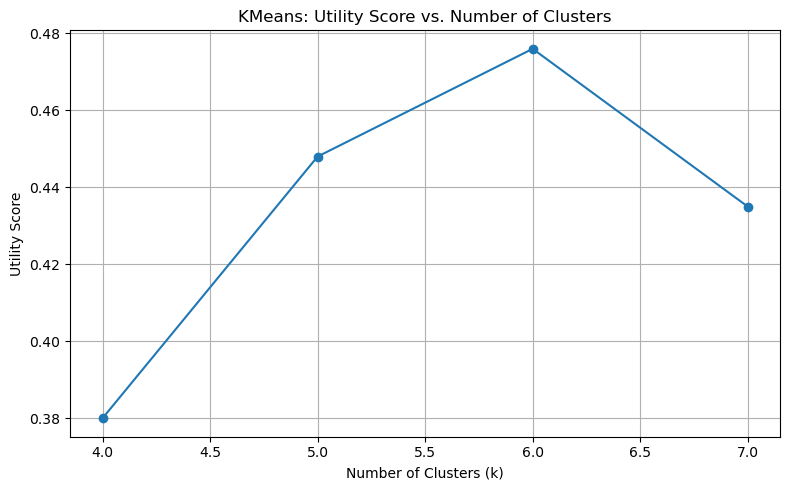

In [400]:


# Show top configs
display(kmeans_results_df)

# Sort by number of clusters (not silhouette) just for plotting
kmeans_results_df_sorted = kmeans_results_df.sort_values(by='n_clusters')

plt.figure(figsize=(8, 5))
plt.plot(
    kmeans_results_df_sorted['n_clusters'],
    kmeans_results_df_sorted['utility_score'],
    marker='o'
)
plt.title("KMeans: Utility Score vs. Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Utility Score")
plt.grid(True)
plt.tight_layout()
plt.show()


## Hyperparameter tuning Agglomerative Model

In [402]:
# Define parameter ranges
n_clusters_range = range(2, 8)
linkage_methods = ['ward', 'complete', 'average']

# Store results
agglo_results = []

for linkage in linkage_methods:
    for k in n_clusters_range:
        try:
            start_time = time.time()
            agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
            labels = agg.fit_predict(X_cluster)
            runtime = round(time.time() - start_time, 3)

            silhouette = silhouette_score(X_cluster, labels)

            # Proportions and usability (normalized!)
            counts = Counter(labels)
            proportions = {k_: round(v / sum(counts.values()), 3) for k_, v in counts.items()}
            props = np.array(list(proportions.values()))
            usable_clusters = sum(0.05 <= v < 0.90 for v in props)
            balance_score = 1 - np.std(props)

            
            # Always print results
            print(f"🔍 linkage={linkage}, k={k}, Silhouette={silhouette:.3f}")
            print(f"   Proportions: {proportions}")
            print(f"   Usable Clusters: {usable_clusters} / {k}")

            # Skip poorly segmented configs
            if usable_clusters < 2:
                print("⚠️ Skipping due to insufficient usable clusters\n")
                continue  # Skip unusable models

            # Composite utility score
            utility = round(0.4 * silhouette + 0.1 * balance_score + 0.5 * (usable_clusters / k), 3)


            # Store results
            agglo_results.append({
                'Model': 'Agglomerative',
                'n_clusters': k,
                'linkage': linkage,
                'silhouette_score': round(silhouette, 3),
                'usable_clusters': usable_clusters,
                'training_time_sec': runtime,
                'utility_score': utility,
                'proportions': proportions
            })

        except Exception as e:
            print(f"❌ Error with linkage={linkage}, k={k}: {e}")

        

# Convert results to DataFrame
agglo_results_df = pd.DataFrame(agglo_results).sort_values(by="utility_score", ascending=False).reset_index(drop=True)




🔍 linkage=ward, k=2, Silhouette=0.986
   Proportions: {0: 1.0, 1: 0.0}
   Usable Clusters: 0 / 2
⚠️ Skipping due to insufficient usable clusters

🔍 linkage=ward, k=3, Silhouette=0.941
   Proportions: {0: 1.0, 2: 0.0, 1: 0.0}
   Usable Clusters: 0 / 3
⚠️ Skipping due to insufficient usable clusters

🔍 linkage=ward, k=4, Silhouette=0.465
   Proportions: {0: 0.933, 1: 0.067, 2: 0.0, 3: 0.0}
   Usable Clusters: 1 / 4
⚠️ Skipping due to insufficient usable clusters

🔍 linkage=ward, k=5, Silhouette=0.157
   Proportions: {1: 0.685, 4: 0.248, 0: 0.067, 2: 0.0, 3: 0.0}
   Usable Clusters: 3 / 5
🔍 linkage=ward, k=6, Silhouette=0.168
   Proportions: {0: 0.685, 4: 0.248, 5: 0.045, 1: 0.021, 2: 0.0, 3: 0.0}
   Usable Clusters: 2 / 6
🔍 linkage=ward, k=7, Silhouette=0.151
   Proportions: {2: 0.58, 4: 0.248, 6: 0.104, 5: 0.045, 1: 0.021, 0: 0.0, 3: 0.0}
   Usable Clusters: 3 / 7
🔍 linkage=complete, k=2, Silhouette=0.986
   Proportions: {0: 1.0, 1: 0.0}
   Usable Clusters: 0 / 2
⚠️ Skipping due to insu

,Model,n_clusters,linkage,silhouette_score,usable_clusters,training_time_sec,utility_score,proportions
0,Agglomerative,5,ward,0.157,3,44.054,0.437,"{1: 0.685, 4: 0.248, 0: 0.067, 2: 0.0, 3: 0.0}"
1,Agglomerative,7,ward,0.151,3,44.208,0.355,"{2: 0.58, 4: 0.248, 6: 0.104, 5: 0.045, 1: 0.021, 0: 0.0, 3: 0.0}"
2,Agglomerative,6,ward,0.168,2,44.162,0.309,"{0: 0.685, 4: 0.248, 5: 0.045, 1: 0.021, 2: 0.0, 3: 0.0}"


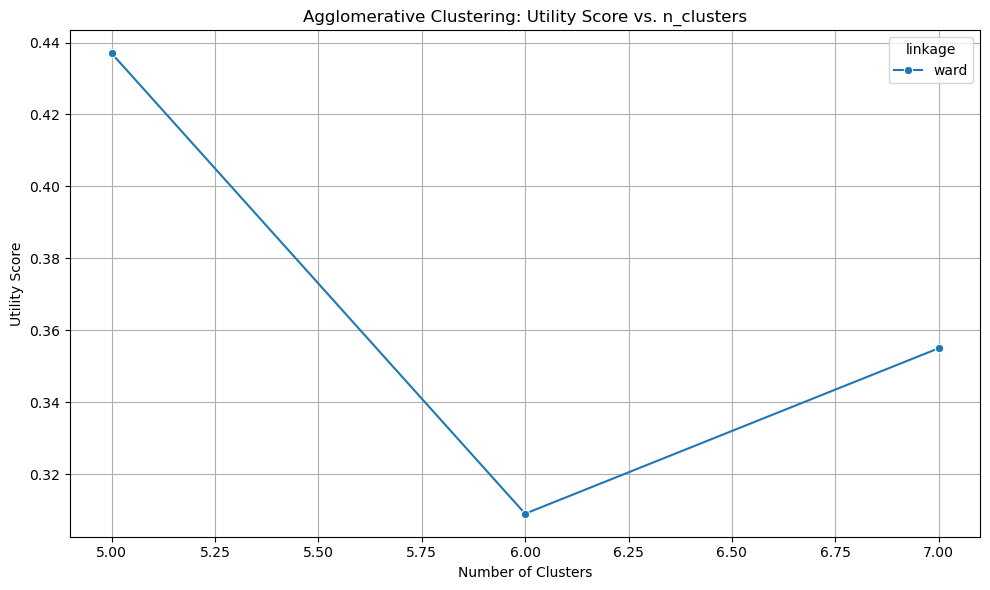

In [403]:

# Show top configs
display(agglo_results_df)

# Sort by number of clusters (not scores) just for plotting
agglo_results_df_sorted = agglo_results_df.sort_values(by='n_clusters')



plt.figure(figsize=(10, 6))
sns.lineplot(data=agglo_results_df_sorted, x='n_clusters', y='utility_score', hue='linkage', marker='o')
plt.title('Agglomerative Clustering: Utility Score vs. n_clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Utility Score')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Combine KMeans and Agglomerative Results

In [406]:
# Combine the two result DataFrames
combined_df = pd.concat([kmeans_results_df, agglo_results_df], ignore_index=True)

# Sort by utility score (best on top)
combined_df_sorted = combined_df.sort_values(by='utility_score', ascending=False).reset_index(drop=True)


combined_df_sorted

,Model,n_clusters,linkage,silhouette_score,usable_clusters,training_time_sec,balance_score,utility_score,proportions
0,KMeans,6,None,0.144,4,3.434,0.855,0.476,"{5: 0.325, 1: 0.282, 0: 0.073, 4: 0.0, 3: 0.0, 2: 0.319}"
1,KMeans,5,None,0.178,3,3.597,0.769,0.448,"{1: 0.605, 2: 0.307, 0: 0.086, 4: 0.002, 3: 0.0}"
2,Agglomerative,5,ward,0.157,3,44.054,NaN,0.437,"{1: 0.685, 4: 0.248, 0: 0.067, 2: 0.0, 3: 0.0}"
3,KMeans,7,None,0.158,4,3.475,0.856,0.435,"{3: 0.323, 1: 0.28, 2: 0.061, 6: 0.019, 5: 0.0, 4: 0.0, 0: 0.317}"
4,KMeans,4,None,0.136,2,3.266,0.757,0.380,"{1: 0.492, 3: 0.014, 2: 0.0, 0: 0.493}"
5,Agglomerative,7,ward,0.151,3,44.208,NaN,0.355,"{2: 0.58, 4: 0.248, 6: 0.104, 5: 0.045, 1: 0.021, 0: 0.0, 3: 0.0}"
6,Agglomerative,6,ward,0.168,2,44.162,NaN,0.309,"{0: 0.685, 4: 0.248, 5: 0.045, 1: 0.021, 2: 0.0, 3: 0.0}"


#### Extract Top Model per Algorithm

In [408]:
top_kmeans = combined_df_sorted[combined_df_sorted['Model'] == 'KMeans'].iloc[0]
top_agglo = combined_df_sorted[combined_df_sorted['Model'] == 'Agglomerative'].iloc[0]


#### Add Final KMeans Cluster Labels

In [410]:
# Fit final KMeans model with best_k
best_k = top_kmeans['n_clusters']
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_cluster)

# Add to user summary
kmeans_df = filtered_train_df[['User-ID']].copy()
kmeans_df['persona_cluster'] = kmeans_labels

# Drop old cluster cols if rerunning
usa_user_summary = usa_user_summary.drop(columns=[col for col in usa_user_summary.columns if col.startswith('persona_cluster')], errors='ignore')
usa_user_summary = usa_user_summary.merge(kmeans_df, on='User-ID', how='left')


#### Add Final Agglomerative Cluster Labels

In [412]:


# Get best parameters from model selection
best_k = top_agglo['n_clusters']
best_linkage = top_agglo['linkage']

# Fit the final Agglomerative model
agglo_final = AgglomerativeClustering(n_clusters=best_k, linkage=best_linkage)
agglo_labels = agglo_final.fit_predict(X_cluster)

# Assign labels to users using filtered_train_df
agglo_df = filtered_train_df[['User-ID']].copy()
agglo_df['agglo_cluster'] = agglo_labels

# Drop any previous agglomerative labels from user summary
usa_user_summary = usa_user_summary.drop(columns=['agglo_cluster'], errors='ignore')

# Merge new labels into usa_user_summary
usa_user_summary = usa_user_summary.merge(agglo_df, on='User-ID', how='left')


#### Compare Final Cluster Labels

In [415]:
# Filter to users that have both cluster assignments (i.e., in training set)
clustered_users = usa_user_summary[
    usa_user_summary['persona_cluster'].notna() & usa_user_summary['agglo_cluster'].notna()
].copy()

# Convert to int if needed (sometimes these are float due to NaNs earlier)
clustered_users['persona_cluster'] = clustered_users['persona_cluster'].astype(int)
clustered_users['agglo_cluster'] = clustered_users['agglo_cluster'].astype(int)

# Create cross-tab
cluster_crosstab = pd.crosstab(clustered_users['persona_cluster'], clustered_users['agglo_cluster'],margins=True,  # adds row and column totals
    margins_name='Total')

# Display
print("📊 Crosstab: KMeans (persona_cluster) vs Agglomerative (agglo_cluster)")
display(cluster_crosstab)


📊 Crosstab: KMeans (persona_cluster) vs Agglomerative (agglo_cluster)


agglo_cluster,0,1,2,3,4,Total
persona_cluster,,,,,,
0,1759,420,0,0,103,2282
1,93,1500,0,0,7184,8777
2,87,9690,0,0,169,9946
3,0,0,0,1,0,1
4,2,0,13,0,0,15
5,141,9722,0,0,276,10139
Total,2082,21332,13,1,7732,31160


In [416]:
# Save to CSV (safe filename and exclude index)
clustered_users.to_csv("clustered_users.csv", index=False)
print("✅ clustered_users exported to clustered_users.csv")


✅ clustered_users exported to clustered_users.csv


### Explore cluster profiles (KMeans)

In [418]:


# Step 1: Compute standard cluster profiles with all numeric data
cluster_profiles = clustered_users.groupby('persona_cluster').mean(numeric_only=True)

# Step 2: Recompute rated_average excluding 0s
rated_avg_filtered = (
    clustered_users[clustered_users['rated_average'] > 0]
    .groupby('persona_cluster')['rated_average']
    .mean()
)

# Step 3: Replace the column in the summary
cluster_profiles['rated_average'] = rated_avg_filtered

# Step 4: Slice and round as needed
numeric_summary = cluster_profiles[
    [ 'read_cnt', 'rated_high_cnt', 'rated_average', 'author_diversity'] #'Age', 'publisher_diversity'
].round(2)


# # Step 2a: Most common favorite era per cluster (categorical)
fav_era_by_cluster = clustered_users.groupby('persona_cluster')[['fav_pub_era']].agg(
     lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown"
 )


# Step 2b: Top 3 favorite authors and most read books per cluster
def top_n(series, n=3):
    return ', '.join(series.value_counts().head(n).index)

kmeans_top3 = clustered_users.groupby('persona_cluster')[['favorite_author', 'mostread_book']].agg(top_n)


# Step 3: Top title words (interest and favorite) per cluster
def top_cluster_words(series, n=10):
    # Define words to exclude
    exclude = {'<sep>', 'none'}
    all_words = ' '.join(series.dropna()).split()
    # Filter out excluded tokens
    filtered_words = [word for word in all_words if word not in exclude]
    # Return top n most common words
    return [word for word, _ in Counter(filtered_words).most_common(n)]

interest_words_by_cluster = clustered_users.groupby('persona_cluster')['interest_title_words'].apply(top_cluster_words)
fav_words_by_cluster = clustered_users.groupby('persona_cluster')['fav_title_words'].apply(top_cluster_words)

# Display all profiles together
print("🧠 Numeric Summary (Selected Features):")
display(numeric_summary)

print("\n📚 Most Common Favorite Era per Cluster:")
display(fav_era_by_cluster)

print("\n📚 Top 3 per Cluster (Kmeans):")
display(kmeans_top3)

print("\n🔤 Top Interest Title Words per Cluster:")
display(interest_words_by_cluster)

print("\n❤️ Top Favorite Title Words per Cluster:")
display(fav_words_by_cluster)


🧠 Numeric Summary (Selected Features):


,read_cnt,rated_high_cnt,rated_average,author_diversity
persona_cluster,,,,
0,41.76,26.38,7.82,0.68
1,2.88,1.60,7.59,0.99
2,2.86,1.57,7.53,0.99
3,5689.00,5490.00,8.86,0.57
4,874.87,449.27,7.32,0.65
5,2.97,1.69,7.69,0.99



📚 Most Common Favorite Era per Cluster:


,fav_pub_era
persona_cluster,
0,1990s
1,1990s
2,1990s
3,2000s
4,1990s
5,1990s



📚 Top 3 per Cluster (Kmeans):


,favorite_author,mostread_book
persona_cluster,,
0,"Janet Evanovich, Dean R. Koontz, Stephen King","A Painted House, Beloved (Plume Contemporary Fiction), A Bend in the Road"
1,"Alice Sebold, John Grisham, Barbara Kingsolver","A Painted House, The Lovely Bones: A Novel, 1st to Die: A Novel"
2,"Stephen King, John Grisham, James Patterson","A Painted House, The Lovely Bones: A Novel, A Child Called \It\"": One Child's Courage to Survive"""
3,Sherryl Jordan,The Raging Quiet
4,,
5,"Barbara Kingsolver, Dean R. Koontz, Nora Roberts","A Bend in the Road, A Heartbreaking Work of Staggering Genius, A Child Called \It\"": One Child's Courage to Survive"""



🔤 Top Interest Title Words per Cluster:


persona_cluster
0           [mystery, life, guide, love, series, woman, world, novel, time, story]
1           [life, mystery, woman, guide, time, love, classic, world, club, story]
2        [life, mystery, guide, love, world, classic, woman, time, club, american]
3    [mystery, romance, star, series, murder, five, first, hardcover, love, death]
4      [mystery, love, classic, library, life, series, modern, book, guide, world]
5           [life, mystery, love, woman, guide, classic, story, world, time, club]
Name: interest_title_words, dtype: object


❤️ Top Favorite Title Words per Cluster:


persona_cluster
0       [life, mystery, guide, series, potter, harry, love, time, classic, secret]
1         [life, classic, guide, love, american, story, woman, club, time, secret]
2       [life, mystery, guide, classic, love, woman, american, world, one, series]
3    [mystery, star, series, murder, hardcover, five, romance, death, first, love]
4    [classic, life, guide, book, love, series, world, mystery, history, american]
5              [life, classic, world, love, woman, guide, story, time, house, one]
Name: fav_title_words, dtype: object

In [419]:
# Combine into one DataFrame for comparison
words_df = pd.DataFrame({
    '🔤 Interest Words': interest_words_by_cluster,
    '❤️ Favorite Words': fav_words_by_cluster
})

# Show full column width
pd.set_option('display.max_colwidth', None)

display(words_df)


,🔤 Interest Words,❤️ Favorite Words
persona_cluster,,
0,"[mystery, life, guide, love, series, woman, world, novel, time, story]","[life, mystery, guide, series, potter, harry, love, time, classic, secret]"
1,"[life, mystery, woman, guide, time, love, classic, world, club, story]","[life, classic, guide, love, american, story, woman, club, time, secret]"
2,"[life, mystery, guide, love, world, classic, woman, time, club, american]","[life, mystery, guide, classic, love, woman, american, world, one, series]"
3,"[mystery, romance, star, series, murder, five, first, hardcover, love, death]","[mystery, star, series, murder, hardcover, five, romance, death, first, love]"
4,"[mystery, love, classic, library, life, series, modern, book, guide, world]","[classic, life, guide, book, love, series, world, mystery, history, american]"
5,"[life, mystery, love, woman, guide, classic, story, world, time, club]","[life, classic, world, love, woman, guide, story, time, house, one]"


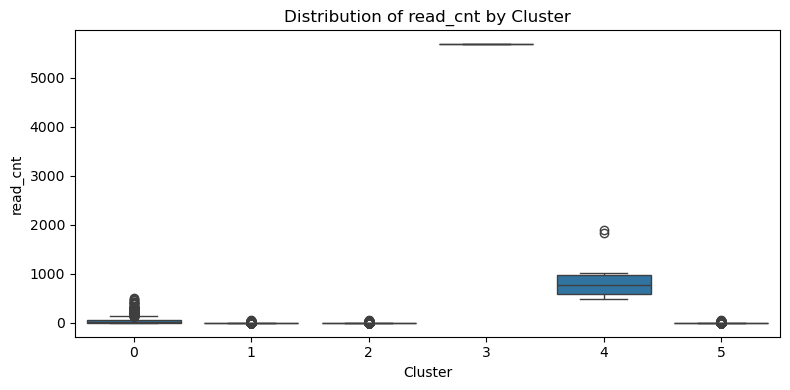

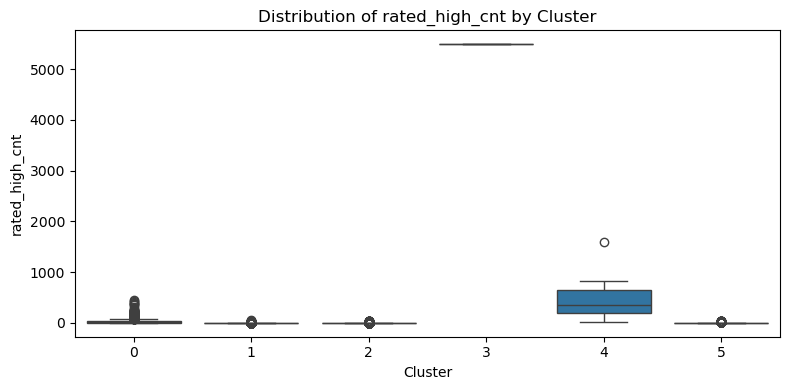

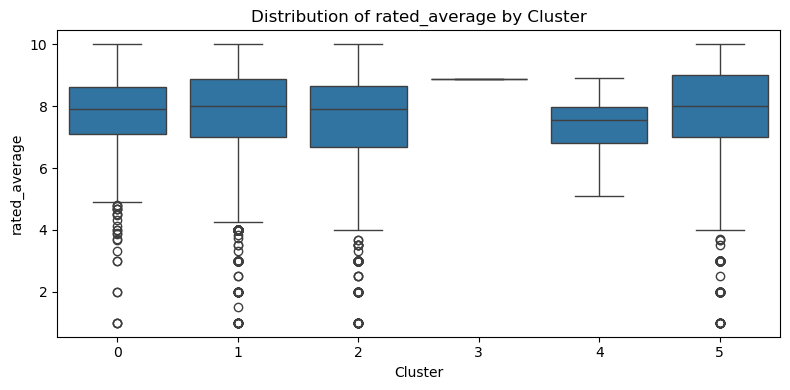

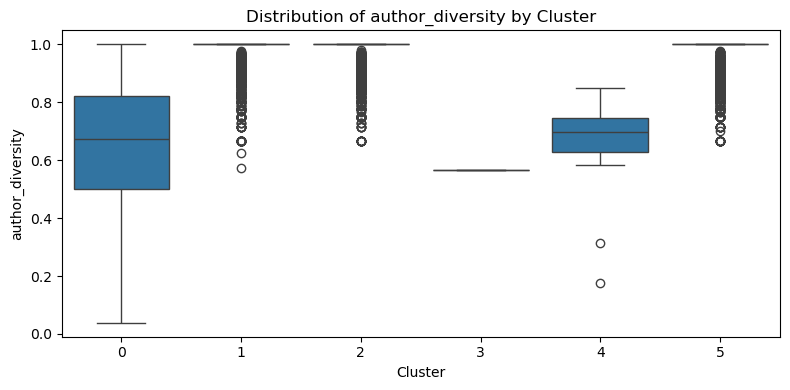

In [420]:
# Plot
for feature in numeric_summary:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=clustered_users, x='persona_cluster', y=feature)
    plt.title(f'Distribution of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

### Explore cluster profiles (Agglomerative Clustering)

In [423]:
# Agglomerative Profiling

# Step 1: Compute standard cluster profiles with all numeric data
agglo_profiles = clustered_users.groupby('agglo_cluster').mean(numeric_only=True)

# Step 2: Recompute rated_average excluding 0s
rated_avg_filtered_agglo = (
    clustered_users[clustered_users['rated_average'] > 0]
    .groupby('agglo_cluster')['rated_average']
    .mean()
)

# Step 3: Replace the column in the summary
agglo_profiles['rated_average'] = rated_avg_filtered_agglo

# Step 4: Slice and round as needed
agglo_numeric_summary = agglo_profiles[
    ['Age', 'read_cnt', 'rated_high_cnt', 'rated_average', 'author_diversity', 'publisher_diversity']
].round(2)

# Step 5a: Most common favorite era per cluster (categorical)
agglo_fav_era = clustered_users.groupby('agglo_cluster')[['fav_pub_era']].agg(
    lambda x: x.mode().iloc[0] if not x.mode().empty else "unknown"
)

# Step 5b: Top 3 favorite authors and most read books per cluster
def top_n(series, n=3):
    return ', '.join(series.value_counts().head(n).index)

agglo_top3 = clustered_users.groupby('agglo_cluster')[['favorite_author', 'mostread_book']].agg(top_n)


# Step 6: Top title words (interest and favorite) per cluster
agglo_interest_words = clustered_users.groupby('agglo_cluster')['interest_title_words'].apply(top_cluster_words)
agglo_fav_words = clustered_users.groupby('agglo_cluster')['fav_title_words'].apply(top_cluster_words)

# Display
print("🧠 Numeric Summary (Agglomerative):")
display(agglo_numeric_summary)

print("\n📚 Most Common Favorite Era per Cluster (Agglomerative):")
display(agglo_fav_era)

print("\n📚 Top 3 per Cluster (Agglomerative):")
display(agglo_top3)

print("\n🔤 Top Interest Title Words per Cluster (Agglomerative):")
display(agglo_interest_words)

print("\n❤️ Top Favorite Title Words per Cluster (Agglomerative):")
display(agglo_fav_words)


🧠 Numeric Summary (Agglomerative):


,Age,read_cnt,rated_high_cnt,rated_average,author_diversity,publisher_diversity
agglo_cluster,,,,,,
0,36.37,39.67,25.72,7.94,0.66,0.65
1,37.37,3.44,1.85,7.46,0.99,0.97
2,38.67,933.85,479.38,7.28,0.63,0.30
3,52.0,5689.00,5490.00,8.86,0.57,0.06
4,38.88,3.11,1.88,7.97,0.99,0.97



📚 Most Common Favorite Era per Cluster (Agglomerative):


,fav_pub_era
agglo_cluster,
0,1990s
1,1990s
2,1990s
3,2000s
4,1990s



📚 Top 3 per Cluster (Agglomerative):


,favorite_author,mostread_book
agglo_cluster,,
0,"Janet Evanovich, Stephen King, Anne Rice","A Painted House, One for the Money (Stephanie Plum Novels (Paperback)), Beloved (Plume Contemporary Fiction)"
1,"John Grisham, Stephen King, James Patterson","A Heartbreaking Work of Staggering Genius, A Painted House, The Lovely Bones: A Novel"
2,,
3,Sherryl Jordan,The Raging Quiet
4,"Dean R. Koontz, Alice Sebold, Barbara Kingsolver","A Painted House, Divine Secrets of the Ya-Ya Sisterhood: A Novel, Angels &amp; Demons"



🔤 Top Interest Title Words per Cluster (Agglomerative):


agglo_cluster
0           [mystery, life, guide, series, love, time, woman, novel, world, story]
1           [life, mystery, love, guide, world, woman, classic, time, story, club]
2     [mystery, classic, love, library, series, modern, life, book, little, guide]
3    [mystery, romance, star, series, murder, five, first, hardcover, love, death]
4           [life, mystery, woman, love, world, story, classic, club, time, guide]
Name: interest_title_words, dtype: object


❤️ Top Favorite Title Words per Cluster (Agglomerative):


agglo_cluster
0        [life, mystery, guide, series, classic, time, love, world, potter, harry]
1         [life, classic, love, guide, mystery, woman, world, time, one, american]
2    [classic, life, guide, love, series, world, mystery, book, history, american]
3    [mystery, star, series, murder, hardcover, five, romance, death, first, love]
4      [life, classic, love, guide, story, club, world, mystery, secret, american]
Name: fav_title_words, dtype: object



## 📚 Persona Profiles

---

### 🧑‍💼 **Persona 0: The Loyal Devourer**

> 🧭 “I read a lot and stick with what I know — mystery, life stories, and trusted authors.”

* **Users:** 2,282 (7.3%)
* **Books Read (avg):** 41.8
* **Top Authors:** Janet Evanovich, Dean R. Koontz, Stephen King
* **Most Read Books:** *A Painted House*, *Beloved*, *A Bend in the Road*
* **Top Interest Title Words:** `mystery`, `life`, `guide`, `love`, `series`, `woman`
* **Top Favorite Title Words:** `life`, `mystery`, `series`, `potter`, `love`, `classic`

**Behavioral Traits:**
Reads heavily and loyally — drawn to mystery and emotionally rich fiction, often from trusted series authors.

**💡 Strategy Recommendation:**

* Highlight next-in-series and favorite-author alerts
* Offer “reading streak” challenges or loyalty badges
* Personalize feeds with author collections and lifetime stats

---

### 📖 **Persona 1: The Sentimental Curator**

> 💬 “I want emotional, literary stories that stay with me — even if I only read a few.”

* **Users:** 8,777 (28.2%)
* **Books Read (avg):** 2.9
* **Top Authors:** Alice Sebold, John Grisham, Barbara Kingsolver
* **Most Read Books:** *A Painted House*, *The Lovely Bones*, *1st to Die*
* **Top Interest Title Words:** `life`, `mystery`, `woman`, `guide`, `love`
* **Top Favorite Title Words:** `life`, `classic`, `woman`, `american`, `time`

**Behavioral Traits:**
Emotionally selective and values literary quality. Explores occasionally but intentionally.

**💡 Strategy Recommendation:**

* Promote titles with strong emotional hooks
* Offer curated lists like “Stories That Stay With You”
* Create personalized mini-challenges (e.g., 3 books in 3 months)

---

### 👻 **Persona 2: The Thrill Seeker**

> 👁️ “I’m into big names and dark stories — thrillers, crime, and dramatic plots.”

* **Users:** 9,946 (31.9%)
* **Books Read (avg):** 2.9
* **Top Authors:** Stephen King, John Grisham, James Patterson
* **Most Read Books:** *A Painted House*, *The Lovely Bones*, *A Child Called 'It'*
* **Top Interest Title Words:** `mystery`, `romance`, `series`, `hardcover`, `love`, `death`
* **Top Favorite Title Words:** `mystery`, `series`, `romance`, `death`, `history`, `love`

**Behavioral Traits:**
Drawn to dark, high-drama fiction by popular authors. Engages lightly but consistently with high-profile content.

**💡 Strategy Recommendation:**

* Surface trending thrillers and crime fiction
* Feature suspense bundles or “like Stephen King?” tracks
* Use high-urgency copy in re-engagement messaging

---

### 🌟 **Persona 3: Outlier - Excluded**

* **Users:** 1 (outlier)

**💡 Strategy Recommendation:**
Exclude from persona-driven marketing; handle as individual exception or test case.

---

### 📖 **Persona 4: Outlier - Excluded**

* **Users:** 15

**💡 Strategy Recommendation:**
Exclude from persona-driven marketing; handle as individual exception or test case.

---

### 🌍 **Persona 5: The Curious Explorer**

> 🌱 “I explore new voices and ideas, but I don’t stay long — I sample and move on.”

* **Users:** 10,139 (32.6%)
* **Books Read (avg):** 2.97
* **Top Authors:** Barbara Kingsolver, Dean R. Koontz, Nora Roberts
* **Most Read Books:** *A Bend in the Road*, *A Heartbreaking Work of Staggering Genius*, *A Child Called 'It'*
* **Top Interest Title Words:** `life`, `mystery`, `love`, `classic`, `club`
* **Top Favorite Title Words:** `life`, `classic`, `world`, `woman`, `guide`

**Behavioral Traits:**
Light readers with globally curious, socially reflective interests. Sample widely, value perspective.

**💡 Strategy Recommendation:**

* Promote globally relevant or award-winning titles
* Offer “worldview expanding” collections or challenges
* Use discovery-based messaging (e.g., “Expand your bookshelf”)

